⚡ In this project, I built a couple of UNet-based models for the task of Multiclass Semantic Segmentation of satellite images of Dubai to compare their performance.

I built 5 models including the classic UNet and Vision-Transformer-based UNet (UNETR).
The other 3 models are variations of it (VGG10-UNet, Densenet-121-Unet, Attention-UNet)

In conclusion, using 2088 images to train models, Densenet-121-Unet achieved the best performance with an accuracy of 89% compared to others. 

In [4]:
# Import libraries
import os
import cv2
import IPython
import numpy as np
import pandas as pd
from PIL import Image
from patchify import patchify
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Model , load_model
from keras.applications import VGG19
from keras.applications import DenseNet121
from keras.applications import EfficientNetB0
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [5]:
# Image config
img_size = 256
num_channels = 3
input_shape = (img_size, img_size, num_channels)

# MinMaxScaler for rescaling each variable to a range of 0-1
scaler = MinMaxScaler()

In [6]:
# The dataset consists of 72 aerial images of Dubai & annotated with pixel-wise semantic segmentation in 6 classes.
# https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery
root_folder = './SemanticSegmentationDataset'

In [7]:
# Raw input images are of various sizes, thus we should capture all images into numpy arrays,
# then crop them into the nearest size which is divisible by 256 (img_size), following this cut them into a fixed-size and extract 256X256 patches.
# In total => 1035 patches
img_dataset =[]

for path , subdirs, files in os.walk(root_folder):

    # name of each direcory
    dir_name = path.split(os.path.sep)[-1]

    if dir_name== 'images':
        print('-----------------------------------------------\n', 'Image Directory Path: ', path)

        # list of images in each 'image' directory
        images_lst = os.listdir(path)
        images_lst.sort()

        for i , img in enumerate(images_lst):
            if img.endswith('.jpg'):
                print('-------------------\n', img)

                #read images in RGB
                image = cv2.imread(path+ '/' + img , 1)
                print(' image shape: ',image.shape)

                # images are cropped from their top and left corners to the nearest size that is divisible by 256
                sizeX = (image.shape[1] // img_size) * img_size
                sizeY = (image.shape[0] // img_size) * img_size
                image = Image.fromarray(image)
                image = image.crop((0,0,sizeX,sizeY))

                # convert images into numpy array
                image = np.array(image)

                # cut up images into non-overlapped 256x256 pieces
                patched_imgs = patchify(image , (img_size,img_size,3) , step= img_size)
                print(' patche shape: ',patched_imgs.shape)

                for i in range(patched_imgs.shape[0]):
                    for j in range(patched_imgs.shape[1]):
                        single_patch_img = patched_imgs[i,j,:,:]

                        # normalize images via MinMaxScaler => value between 0 and 1
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]

                        # add all patches to a list
                        img_dataset.append(single_patch_img)

-----------------------------------------------
 Image Directory Path:  ./SemanticSegmentationDataset/Tile 3/images
-------------------
 image_part_001.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_002.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_003.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_004.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_005.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_006.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_007.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_008.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------


In [8]:
msk_dataset = []

for path, subdirs, files in os.walk(root_folder):

    # name of each direcory
    dirname = path.split(os.path.sep)[-1]

    if dirname == 'masks':
        print('-----------------------------------------------\n', 'Mask Directory Path: ', path)

        # list of masks in each 'mask' directory
        masks_lst = os.listdir(path)
        masks_lst.sort()


        for i, msk in enumerate(masks_lst):
            if msk.endswith(".png"):
                print('-------------------\n' ,msk)

                #Read each mask as RGB
                mask = cv2.imread(path+"/"+msk, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                print(' mask shape: ', mask.shape)

                # masks are cropped from their top and left corners to the nearest size that is divisible by 256
                sizeX = (mask.shape[1]//img_size)*img_size
                sizeY = (mask.shape[0]//img_size)*img_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, sizeX, sizeY))

                # convert masks into numpy array
                mask = np.array(mask)

                # cut up masks into 256x256 pieces for data augmentation
                patched_masks = patchify(mask , (img_size,img_size,3) , step= img_size)
                print(' patche shape: ', patched_masks.shape)

                for i in range(patched_masks.shape[0]):
                    for j in range(patched_masks.shape[1]):

                        single_patch_mask = patched_masks[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]

                        # add all patched masks to a list
                        msk_dataset.append(single_patch_mask)

-----------------------------------------------
 Mask Directory Path:  ./SemanticSegmentationDataset/Tile 3/masks
-------------------
 image_part_001.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_002.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_003.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_004.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_005.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_006.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_007.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_008.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_par

In [9]:
img_dataset = np.array(img_dataset)
msk_dataset =  np.array(msk_dataset)

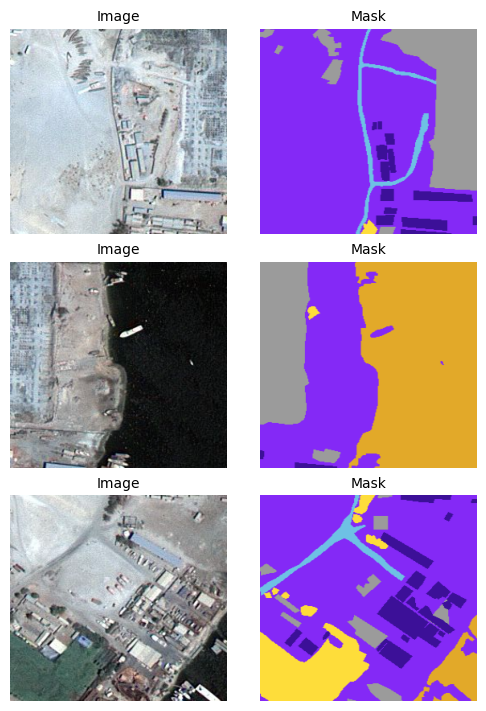

In [ ]:
# Visualise patched images & their corresponding masks
count = 0
i = 0
fig, axs = plt.subplots(3, 2, figsize=(5, 7), constrained_layout=True)

for mask in msk_dataset:
    if (mask.all()):
        # read images
        axs[count][0].imshow(cv2.resize(img_dataset[i], (270,256)))
        axs[count][0].set_title('Image', fontdict = {'fontsize':10})
        axs[count][0].axis(False)

        # read masks
        axs[count][1].imshow(cv2.resize(msk_dataset[i], (270,256)))
        axs[count][1].set_title('Mask' , fontdict = {'fontsize':10})
        axs[count][1].axis(False)

        count +=1
    i += 1
    if (count==3):
        break

plt.show()

In [10]:
# Mask are RGB and information is provided in HEX color code, so we need to:
# 1) Convert HEX labels to RGB values--------------------------------------------------------------------------
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4)))
print('Building :' , Building)

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4)))
print('Land :' , Land)

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4)))
print('Road :' , Road)

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4)))
print('Vegetation :' , Vegetation)

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4)))
print('Water :' , Water)

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4)))
print('Unlabeled :' , Unlabeled)


# 2) Convert RGB labels to integer values--------------------------------------------------------------------------
def rgb_to_2D_label(msk_dt):
    # create a new array of given shape and type of each row of mask dataset, filled with zeros
    label_seg = np.zeros(msk_dt.shape, dtype = np.uint8)

    label_seg [np.all(msk_dt == Building,axis=-1)] = 0
    label_seg [np.all(msk_dt==Land,axis=-1)] = 1
    label_seg [np.all(msk_dt==Road,axis=-1)] = 2
    label_seg [np.all(msk_dt==Vegetation,axis=-1)] = 3
    label_seg [np.all(msk_dt==Water,axis=-1)] = 4
    label_seg [np.all(msk_dt==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]
    return label_seg

labels = []
for i in range(msk_dataset.shape[0]):
    label = rgb_to_2D_label(msk_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)
print("-----------------------------")
print(labels.shape)


# 3) one-hot encode labels, since it's a multiclass segmentation task ----------------------------------------------
print("-----------------------------")
print("all labels : ", np.unique(labels))
num_classes = len(np.unique(labels)) #6
labels_cat = to_categorical(labels, num_classes=num_classes)

Building : [ 60  16 152]
Land : [132  41 246]
Road : [110 193 228]
Vegetation : [254 221  58]
Water : [226 169  41]
Unlabeled : [155 155 155]
-----------------------------
(1305, 256, 256, 1)
-----------------------------
all labels :  [0 1 2 3 4 5]


In [11]:
# split data into training & testing dataset
X_train, X_test, y_train, y_test = train_test_split(img_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [12]:
## Image Augmentation
# Vertical Image
Vx = [np.flip(x, axis=0) for x in X_train]
Vy = [np.flip(x, axis=0) for x in y_train]

X_train = np.append(X_train, Vx, axis=0)
y_train = np.append(y_train, Vy, axis=0)

In [13]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (2088, 256, 256, 3)
y_train shape:  (2088, 256, 256, 6)
X_test shape:  (261, 256, 256, 3)
y_test shape:  (261, 256, 256, 6)


# U-Net Model

In [ ]:
# U-net model 2
def encoding_block(inputs, filters, dropout_probability=0, max_pooling=True):

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(inputs)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    skip_connection = C

    if max_pooling:
        next_layer = layers.MaxPooling2D(pool_size=(2, 2))(C)
    else:
        next_layer = C

    return next_layer, skip_connection

In [ ]:
def decoding_block(inputs, skip_connection_input, filters):
    CT = layers.Conv2DTranspose(filters, 3, strides=(2,2), padding="same", kernel_initializer="he_normal")(inputs)

    residual_connection = layers.concatenate([CT, skip_connection_input], axis=3)

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(residual_connection)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    return C

In [ ]:
def unet_model(input_size, filters, n_classes):
    inputs = layers.Input(input_size)

    # Encoder
    C1, S1 = encoding_block(inputs, filters, max_pooling=True)
    C2, S2 = encoding_block(C1, filters * 2, max_pooling=True)
    C3, S3 = encoding_block(C2, filters * 4, max_pooling=True)
    C4, S4 = encoding_block(C3, filters * 8, max_pooling=True)

    C5, S5 = encoding_block(C4, filters * 16, max_pooling=False)

    # Decoder
    U6 = decoding_block(C5, S4, filters * 8)
    U7 = decoding_block(U6, S3,  filters * 4)
    U8 = decoding_block(U7, S2,  filters = filters * 2)
    U9 = decoding_block(U8, S1,  filters = filters)

    C10 = layers.Conv2D(filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(U9)

    C11 = layers.Conv2D(filters = n_classes, kernel_size = (1,1), activation='softmax', padding='same')(C10)

    model = Model(inputs=inputs, outputs=C11)

    return model

In [ ]:
unet_model = unet_model((img_size, img_size, num_channels), filters=32, n_classes=num_classes)
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_27 (Conv2D)          (None, 256, 256, 32)         896       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_24 (Ba  (None, 256, 256, 32)         128       ['conv2d_27[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_24 (Activation)  (None, 256, 256, 32)         0         ['batch_normalization_24[0

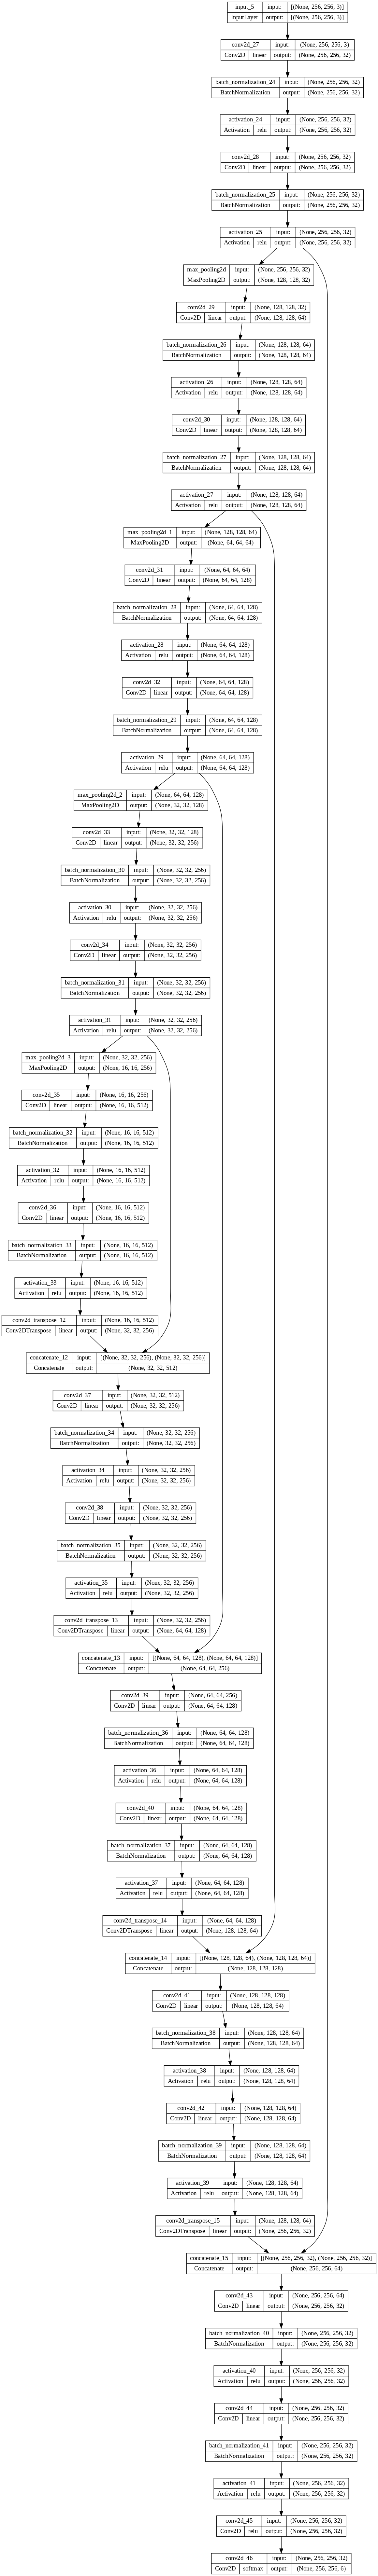

In [ ]:
keras.utils.plot_model(
    unet_model,
    to_file='UNet_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [ ]:

# compile the model
unet_model.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

checkpoint_unet = ModelCheckpoint("./CNN_UNet.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping_unet = EarlyStopping(monitor='val_acc', patience=20,verbose=1, restore_best_weights=True)
reduce_learningrate_unet = ReduceLROnPlateau(monitor='val_acc',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

callbacks_list_unet = [early_stopping_unet,checkpoint_unet,reduce_learningrate_unet]

In [ ]:
history_unet = unet_model.fit(X_train, y_train, batch_size = 16, verbose=1, epochs= 30, validation_data=(X_test, y_test), callbacks = callbacks_list_unet)

Epoch 1/30
131/131 [==============================] - ETA: 0s - loss: 0.8056 - accuracy: 0.7249

131/131 [==============================] - 36s 159ms/step - loss: 0.8056 - accuracy: 0.7249 - val_loss: 0.9021 - val_accuracy: 0.6835 - lr: 0.0010
Epoch 2/30
131/131 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.7754

131/131 [==============================] - 17s 127ms/step - loss: 0.6536 - accuracy: 0.7754 - val_loss: 0.7597 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 3/30
131/131 [==============================] - ETA: 0s - loss: 0.5924 - accuracy: 0.7957

131/131 [==============================] - 17s 127ms/step - loss: 0.5924 - accuracy: 0.7957 - val_loss: 0.6246 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 4/30
131/131 [==============================] - ETA: 0s - loss: 0.5640 - accuracy: 0.8050

131/131 [==============================] - 17s 127ms/step - loss: 0.5640 - accuracy: 0.8050 - val_loss: 0.6330 - val_accuracy: 0.7970 - lr: 0.0010
Epoch 5/30
131/131 [==============================] - ETA: 0s - loss: 0.5420 - accuracy: 0.8140

131/131 [==============================] - 17s 127ms/step - loss: 0.5420 - accuracy: 0.8140 - val_loss: 0.4812 - val_accuracy: 0.8389 - lr: 0.0010
Epoch 6/30
131/131 [==============================] - ETA: 0s - loss: 0.5286 - accuracy: 0.8172

131/131 [==============================] - 17s 127ms/step - loss: 0.5286 - accuracy: 0.8172 - val_loss: 0.4861 - val_accuracy: 0.8414 - lr: 0.0010
Epoch 7/30
131/131 [==============================] - ETA: 0s - loss: 0.5123 - accuracy: 0.8225

131/131 [==============================] - 17s 128ms/step - loss: 0.5123 - accuracy: 0.8225 - val_loss: 0.5415 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 8/30
131/131 [==============================] - ETA: 0s - loss: 0.4994 - accuracy: 0.8257

131/131 [==============================] - 17s 126ms/step - loss: 0.4994 - accuracy: 0.8257 - val_loss: 0.4790 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 9/30
131/131 [==============================] - ETA: 0s - loss: 0.4897 - accuracy: 0.8298

131/131 [==============================] - 17s 128ms/step - loss: 0.4897 - accuracy: 0.8298 - val_loss: 0.6569 - val_accuracy: 0.7913 - lr: 0.0010
Epoch 10/30
131/131 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.8312

131/131 [==============================] - 17s 127ms/step - loss: 0.4846 - accuracy: 0.8312 - val_loss: 0.5410 - val_accuracy: 0.8145 - lr: 0.0010
Epoch 11/30
131/131 [==============================] - ETA: 0s - loss: 0.4875 - accuracy: 0.8303

131/131 [==============================] - 17s 127ms/step - loss: 0.4875 - accuracy: 0.8303 - val_loss: 0.4528 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 12/30
131/131 [==============================] - ETA: 0s - loss: 0.4706 - accuracy: 0.8347

131/131 [==============================] - 17s 128ms/step - loss: 0.4706 - accuracy: 0.8347 - val_loss: 0.4872 - val_accuracy: 0.8368 - lr: 0.0010
Epoch 13/30
131/131 [==============================] - ETA: 0s - loss: 0.4613 - accuracy: 0.8394

131/131 [==============================] - 17s 127ms/step - loss: 0.4613 - accuracy: 0.8394 - val_loss: 0.4331 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 14/30
131/131 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.8422

131/131 [==============================] - 17s 128ms/step - loss: 0.4484 - accuracy: 0.8422 - val_loss: 0.4497 - val_accuracy: 0.8481 - lr: 0.0010
Epoch 15/30
131/131 [==============================] - ETA: 0s - loss: 0.4498 - accuracy: 0.8421

131/131 [==============================] - 17s 127ms/step - loss: 0.4498 - accuracy: 0.8421 - val_loss: 0.4787 - val_accuracy: 0.8427 - lr: 0.0010
Epoch 16/30
131/131 [==============================] - ETA: 0s - loss: 0.4371 - accuracy: 0.8452

131/131 [==============================] - 17s 127ms/step - loss: 0.4371 - accuracy: 0.8452 - val_loss: 0.4050 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 17/30
131/131 [==============================] - ETA: 0s - loss: 0.4506 - accuracy: 0.8415

131/131 [==============================] - 17s 127ms/step - loss: 0.4506 - accuracy: 0.8415 - val_loss: 0.4484 - val_accuracy: 0.8497 - lr: 0.0010
Epoch 18/30
131/131 [==============================] - ETA: 0s - loss: 0.4355 - accuracy: 0.8464

131/131 [==============================] - 17s 126ms/step - loss: 0.4355 - accuracy: 0.8464 - val_loss: 0.4209 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 19/30
131/131 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.8397

131/131 [==============================] - 17s 126ms/step - loss: 0.4524 - accuracy: 0.8397 - val_loss: 0.4382 - val_accuracy: 0.8552 - lr: 0.0010
Epoch 20/30
131/131 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.8504

131/131 [==============================] - 17s 127ms/step - loss: 0.4195 - accuracy: 0.8504 - val_loss: 0.4479 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 21/30
131/131 [==============================] - ETA: 0s - loss: 0.4277 - accuracy: 0.8488

131/131 [==============================] - 17s 127ms/step - loss: 0.4277 - accuracy: 0.8488 - val_loss: 0.5760 - val_accuracy: 0.8026 - lr: 0.0010
Epoch 22/30
131/131 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.8483

131/131 [==============================] - 17s 127ms/step - loss: 0.4273 - accuracy: 0.8483 - val_loss: 0.4231 - val_accuracy: 0.8558 - lr: 0.0010
Epoch 23/30
131/131 [==============================] - ETA: 0s - loss: 0.4249 - accuracy: 0.8491

131/131 [==============================] - 17s 127ms/step - loss: 0.4249 - accuracy: 0.8491 - val_loss: 0.4239 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 24/30
131/131 [==============================] - ETA: 0s - loss: 0.3980 - accuracy: 0.8583

131/131 [==============================] - 17s 127ms/step - loss: 0.3980 - accuracy: 0.8583 - val_loss: 0.3975 - val_accuracy: 0.8694 - lr: 0.0010
Epoch 25/30
131/131 [==============================] - ETA: 0s - loss: 0.3987 - accuracy: 0.8580

131/131 [==============================] - 17s 127ms/step - loss: 0.3987 - accuracy: 0.8580 - val_loss: 0.4287 - val_accuracy: 0.8616 - lr: 0.0010
Epoch 26/30
131/131 [==============================] - ETA: 0s - loss: 0.4191 - accuracy: 0.8525

131/131 [==============================] - 17s 127ms/step - loss: 0.4191 - accuracy: 0.8525 - val_loss: 0.4079 - val_accuracy: 0.8638 - lr: 0.0010
Epoch 27/30
131/131 [==============================] - ETA: 0s - loss: 0.3932 - accuracy: 0.8599

131/131 [==============================] - 17s 128ms/step - loss: 0.3932 - accuracy: 0.8599 - val_loss: 0.4024 - val_accuracy: 0.8699 - lr: 0.0010
Epoch 28/30
131/131 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.8631

131/131 [==============================] - 17s 128ms/step - loss: 0.3837 - accuracy: 0.8631 - val_loss: 0.4205 - val_accuracy: 0.8603 - lr: 0.0010
Epoch 29/30
131/131 [==============================] - ETA: 0s - loss: 0.3799 - accuracy: 0.8635

131/131 [==============================] - 17s 128ms/step - loss: 0.3799 - accuracy: 0.8635 - val_loss: 0.3794 - val_accuracy: 0.8728 - lr: 0.0010
Epoch 30/30
131/131 [==============================] - ETA: 0s - loss: 0.3810 - accuracy: 0.8641

131/131 [==============================] - 17s 128ms/step - loss: 0.3810 - accuracy: 0.8641 - val_loss: 0.3762 - val_accuracy: 0.8740 - lr: 0.0010


In [ ]:
df_result_unet = pd.DataFrame(history_unet.history)
df_result_unet

loss  accuracy  val_loss  val_accuracy     lr
0   0.805611  0.724913  0.902062      0.683471  0.001
1   0.653645  0.775351  0.759696      0.741864  0.001
2   0.592427  0.795719  0.624615      0.790034  0.001
3   0.564002  0.804967  0.633043      0.796981  0.001
4   0.542018  0.814033  0.481215      0.838856  0.001
5   0.528629  0.817213  0.486078      0.841426  0.001
6   0.512337  0.822519  0.541468      0.822889  0.001
7   0.499393  0.825663  0.478955      0.846675  0.001
8   0.489702  0.829829  0.656862      0.791347  0.001
9   0.484633  0.831202  0.541044      0.814520  0.001
10  0.487490  0.830299  0.452819      0.854285  0.001
11  0.470575  0.834726  0.487184      0.836756  0.001
12  0.461306  0.839430  0.433066      0.857955  0.001
13  0.448407  0.842185  0.449721      0.848146  0.001
14  0.449813  0.842060  0.478749      0.842676  0.001
15  0.437067  0.845152  0.405007      0.864304  0.001
16  0.450560  0.841533  0.448436      0.849652  0.001
17  0.435489  0.846388  0.420926      0.861248  0.001
18  0.452384  0.839748  0.438245      0.855246  0.001
19  0.419486  0.850370  0.447902      0.844442  0.001
20  0.427747  0.848819  0.575972      0.802606  0.001
21  0.427342  0.848291  0.423130      0.855761  0.001
22  0.424876  0.849079  0.423929      0.860763  0.001
23  0.397961  0.858349  0.397523      0.869434  0.001
24  0.398726  0.858038  0.428718      0.861644  0.001
25  0.419103  0.852480  0.407913      0.863770  0.001
26  0.393241  0.859892  0.402443      0.869899  0.001
27  0.383707  0.863056  0.420478      0.860265  0.001
28  0.379938  0.863481  0.379415      0.872828  0.001
29  0.380984  0.864073  0.376209      0.874022  0.001

In [ ]:
# evalute model
loss_unet,acc_unet= unet_model.evaluate(X_test, y_test, verbose=1)
print("accuracy:", acc_unet)

9/9 [==============================] - 3s 81ms/step - loss: 0.3762 - accuracy: 0.8740
accuracy: 0.8740218281745911


<Axes: >

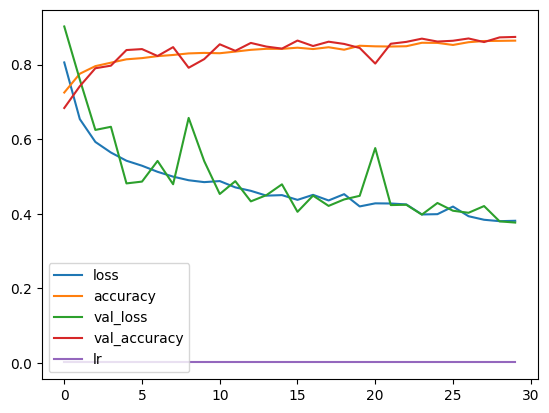

In [ ]:
pd.DataFrame(history_unet.history).plot()

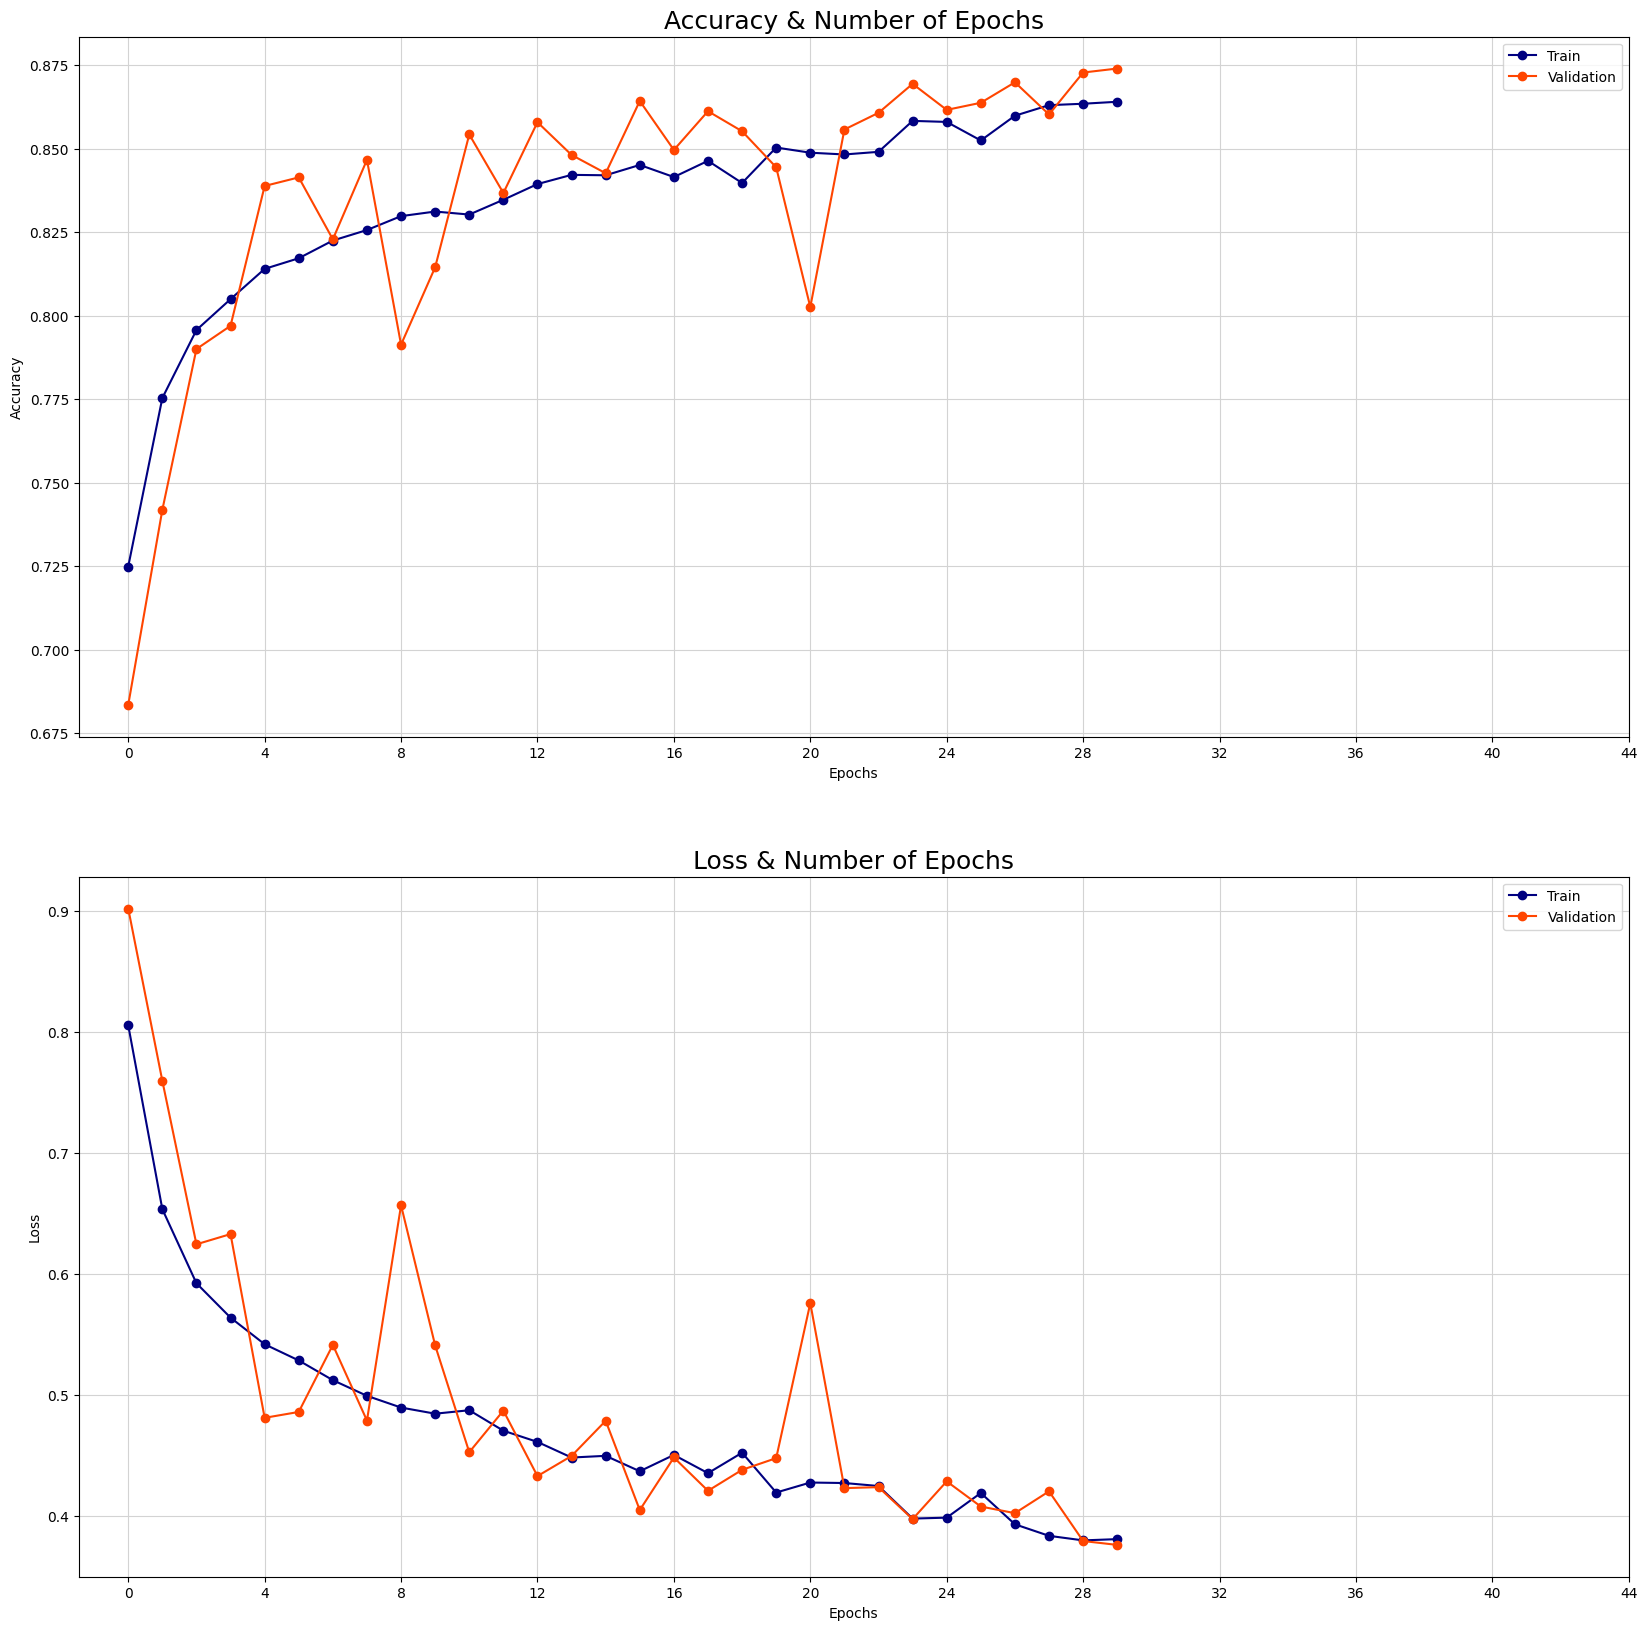

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax = ax.ravel()
metrics_unet = ['Accuracy', 'Loss']

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_unet.history[met], 'o-',color= 'navy')
    ax[i].plot(history_unet.history['val_' + met], 'o-',color= 'orangered')
    ax[i].set_title('{} & Number of Epochs'.format(metrics_unet[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics_unet[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")


In [ ]:
y_pred_unet=unet_model.predict(X_test)

9/9 [==============================] - 1s 73ms/step


In [ ]:
unet_model.save("./CNN_Unet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#VGG19 U-Net Model

In [ ]:
# VGG19 model

def conv_block_VGG19(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def decoder_block_VGG19(inputs, skip_connection_input, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_connection_input])
    x = conv_block_VGG19(x, num_filters)
    return x

In [ ]:
def VGG19_unet(input_size,n_classes):
    inputs = layers.Input(input_size)
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    # encoder
    s1 = vgg19.get_layer("block1_conv2").output      # (256 x 256)
    s2 = vgg19.get_layer("block2_conv2").output      # (128 x 128)
    s3 = vgg19.get_layer("block3_conv4").output      # (64 x 64)
    s4 = vgg19.get_layer("block4_conv4").output      # (32 x 32)

    # bridge
    b1 = vgg19.get_layer("block5_conv4").output       # (16 x 16)

    # decoder
    d1 = decoder_block_VGG19(b1, s4, 256)
    d2 = decoder_block_VGG19(d1, s3, 128)
    d3 = decoder_block_VGG19(d2, s2, 64)
    d4 = decoder_block_VGG19(d3, s1, 32)

    # output
    dropout = layers.Dropout(0.3)(d4)
    outputs = layers.Conv2D(n_classes, 1, padding="same", activation="softmax")(dropout)

    model_VGG19 = Model(inputs, outputs, name="VGG19-UNet")
    return model_VGG19

In [ ]:
model_VGG19 = VGG19_unet((img_size, img_size, num_channels), num_classes)
model_VGG19.summary()

80134624/80134624 [==============================] - 2s 0us/step
Model: "VGG19-UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                        

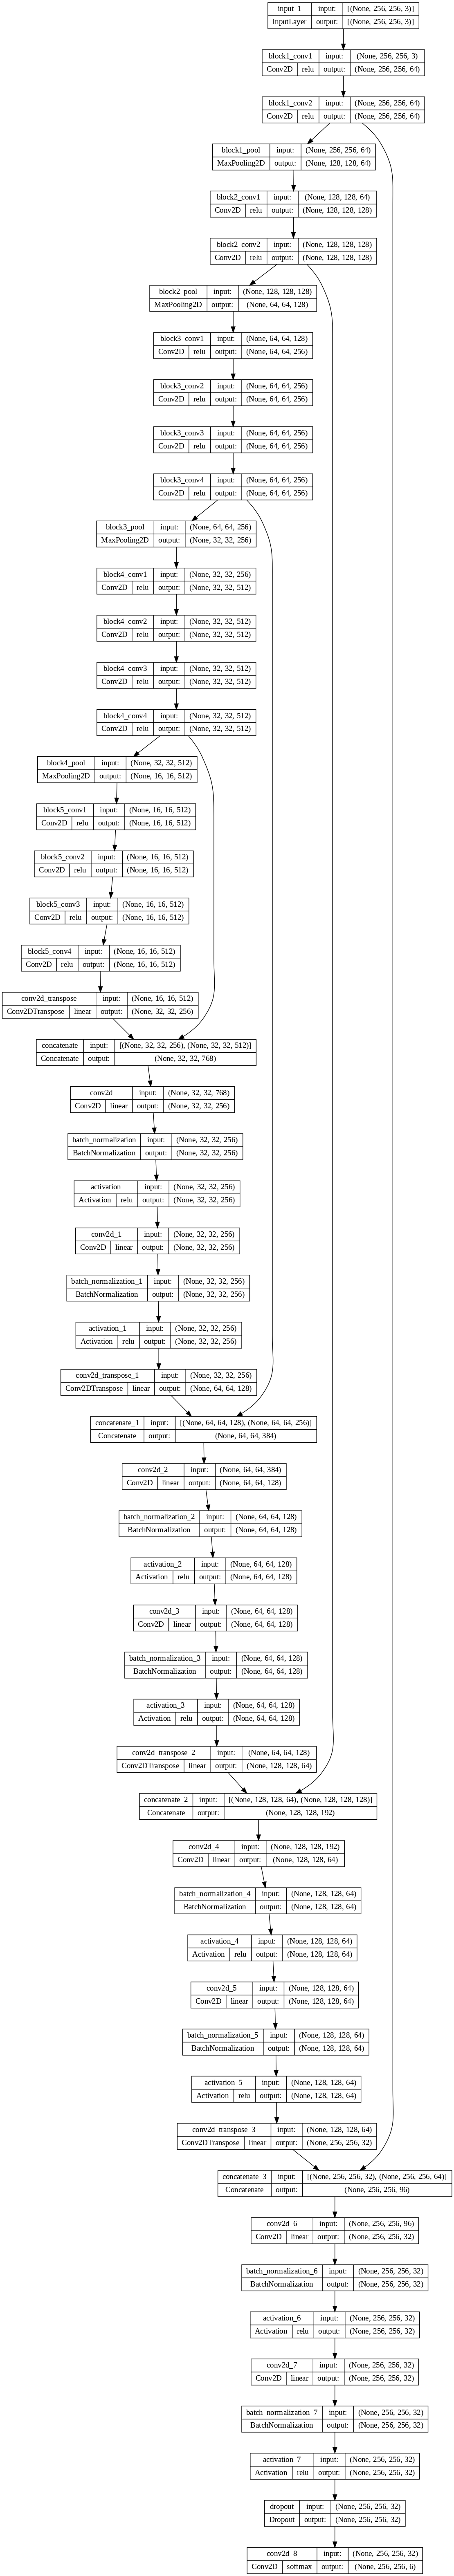

In [ ]:
keras.utils.plot_model(
    model_VGG19,
    to_file='VGG19_UNet_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [ ]:
# compile the model
model_VGG19.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

checkpoint_VGG19 = ModelCheckpoint("./VGG19_UNet.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping_VGG19 = EarlyStopping(monitor='val_acc', patience=20,verbose=1, restore_best_weights=True)
reduce_learningrate_VGG19 = ReduceLROnPlateau(monitor='val_acc',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

callbacks_list_VGG19 = [early_stopping_VGG19,checkpoint_VGG19,reduce_learningrate_VGG19]

In [ ]:
history_VGG19 = model_VGG19.fit(X_train, y_train, batch_size = 16, verbose=1, epochs= 30, validation_data=(X_test, y_test), callbacks = callbacks_list_VGG19)

Epoch 1/30
131/131 [==============================] - ETA: 0s - loss: 0.4704 - accuracy: 0.8413

131/131 [==============================] - 45s 227ms/step - loss: 0.4704 - accuracy: 0.8413 - val_loss: 0.4246 - val_accuracy: 0.8640 - lr: 0.0010
Epoch 2/30
131/131 [==============================] - ETA: 0s - loss: 0.4596 - accuracy: 0.8436

131/131 [==============================] - 29s 224ms/step - loss: 0.4596 - accuracy: 0.8436 - val_loss: 0.3860 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 3/30
131/131 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.8461

131/131 [==============================] - 29s 224ms/step - loss: 0.4525 - accuracy: 0.8461 - val_loss: 0.3888 - val_accuracy: 0.8712 - lr: 0.0010
Epoch 4/30
131/131 [==============================] - ETA: 0s - loss: 0.4499 - accuracy: 0.8475

131/131 [==============================] - 29s 224ms/step - loss: 0.4499 - accuracy: 0.8475 - val_loss: 0.4538 - val_accuracy: 0.8546 - lr: 0.0010
Epoch 5/30
131/131 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.8451

131/131 [==============================] - 29s 224ms/step - loss: 0.4581 - accuracy: 0.8451 - val_loss: 0.4237 - val_accuracy: 0.8540 - lr: 0.0010
Epoch 6/30
131/131 [==============================] - ETA: 0s - loss: 0.4252 - accuracy: 0.8548

131/131 [==============================] - 29s 223ms/step - loss: 0.4252 - accuracy: 0.8548 - val_loss: 0.4191 - val_accuracy: 0.8595 - lr: 0.0010
Epoch 7/30
131/131 [==============================] - ETA: 0s - loss: 0.4126 - accuracy: 0.8590

131/131 [==============================] - 29s 223ms/step - loss: 0.4126 - accuracy: 0.8590 - val_loss: 0.3542 - val_accuracy: 0.8824 - lr: 0.0010
Epoch 8/30
131/131 [==============================] - ETA: 0s - loss: 0.4062 - accuracy: 0.8614

131/131 [==============================] - 29s 223ms/step - loss: 0.4062 - accuracy: 0.8614 - val_loss: 0.3786 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 9/30
131/131 [==============================] - ETA: 0s - loss: 0.4036 - accuracy: 0.8620

131/131 [==============================] - 29s 224ms/step - loss: 0.4036 - accuracy: 0.8620 - val_loss: 0.3554 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 10/30
131/131 [==============================] - ETA: 0s - loss: 0.3935 - accuracy: 0.8649

131/131 [==============================] - 29s 224ms/step - loss: 0.3935 - accuracy: 0.8649 - val_loss: 0.4629 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 11/30
131/131 [==============================] - ETA: 0s - loss: 0.3937 - accuracy: 0.8645

131/131 [==============================] - 29s 223ms/step - loss: 0.3937 - accuracy: 0.8645 - val_loss: 0.3890 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 12/30
131/131 [==============================] - ETA: 0s - loss: 0.3798 - accuracy: 0.8696

131/131 [==============================] - 29s 223ms/step - loss: 0.3798 - accuracy: 0.8696 - val_loss: 0.3703 - val_accuracy: 0.8786 - lr: 0.0010
Epoch 13/30
131/131 [==============================] - ETA: 0s - loss: 0.3660 - accuracy: 0.8736

131/131 [==============================] - 29s 223ms/step - loss: 0.3660 - accuracy: 0.8736 - val_loss: 0.3747 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 14/30
131/131 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8771

131/131 [==============================] - 29s 223ms/step - loss: 0.3578 - accuracy: 0.8771 - val_loss: 0.3538 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 15/30
131/131 [==============================] - ETA: 0s - loss: 0.3533 - accuracy: 0.8789

131/131 [==============================] - 29s 223ms/step - loss: 0.3533 - accuracy: 0.8789 - val_loss: 0.3703 - val_accuracy: 0.8815 - lr: 0.0010
Epoch 16/30
131/131 [==============================] - ETA: 0s - loss: 0.3494 - accuracy: 0.8805

131/131 [==============================] - 29s 224ms/step - loss: 0.3494 - accuracy: 0.8805 - val_loss: 0.3488 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 17/30
131/131 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.8823

131/131 [==============================] - 29s 224ms/step - loss: 0.3432 - accuracy: 0.8823 - val_loss: 0.3635 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 18/30
131/131 [==============================] - ETA: 0s - loss: 0.3307 - accuracy: 0.8867

131/131 [==============================] - 29s 223ms/step - loss: 0.3307 - accuracy: 0.8867 - val_loss: 0.3744 - val_accuracy: 0.8769 - lr: 0.0010
Epoch 19/30
131/131 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 0.8904

131/131 [==============================] - 29s 223ms/step - loss: 0.3193 - accuracy: 0.8904 - val_loss: 0.4243 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 20/30
131/131 [==============================] - ETA: 0s - loss: 0.3155 - accuracy: 0.8909

131/131 [==============================] - 29s 223ms/step - loss: 0.3155 - accuracy: 0.8909 - val_loss: 0.3479 - val_accuracy: 0.8897 - lr: 0.0010
Epoch 21/30
131/131 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.8949

131/131 [==============================] - 29s 223ms/step - loss: 0.3053 - accuracy: 0.8949 - val_loss: 0.4194 - val_accuracy: 0.8742 - lr: 0.0010
Epoch 22/30
131/131 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.8982

131/131 [==============================] - 29s 223ms/step - loss: 0.2948 - accuracy: 0.8982 - val_loss: 0.3650 - val_accuracy: 0.8872 - lr: 0.0010
Epoch 23/30
131/131 [==============================] - ETA: 0s - loss: 0.2931 - accuracy: 0.8981

131/131 [==============================] - 29s 223ms/step - loss: 0.2931 - accuracy: 0.8981 - val_loss: 0.3782 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 24/30
131/131 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.9032

131/131 [==============================] - 29s 223ms/step - loss: 0.2792 - accuracy: 0.9032 - val_loss: 0.3920 - val_accuracy: 0.8826 - lr: 0.0010
Epoch 25/30
131/131 [==============================] - ETA: 0s - loss: 0.3735 - accuracy: 0.8740

131/131 [==============================] - 29s 223ms/step - loss: 0.3735 - accuracy: 0.8740 - val_loss: 0.4542 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 26/30
131/131 [==============================] - ETA: 0s - loss: 0.3010 - accuracy: 0.8964

131/131 [==============================] - 29s 223ms/step - loss: 0.3010 - accuracy: 0.8964 - val_loss: 0.3712 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 27/30
131/131 [==============================] - ETA: 0s - loss: 0.2638 - accuracy: 0.9084

131/131 [==============================] - 29s 223ms/step - loss: 0.2638 - accuracy: 0.9084 - val_loss: 0.3507 - val_accuracy: 0.8909 - lr: 0.0010
Epoch 28/30
131/131 [==============================] - ETA: 0s - loss: 0.2557 - accuracy: 0.9113

131/131 [==============================] - 29s 223ms/step - loss: 0.2557 - accuracy: 0.9113 - val_loss: 0.3716 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 29/30
131/131 [==============================] - ETA: 0s - loss: 0.2423 - accuracy: 0.9155

131/131 [==============================] - 29s 224ms/step - loss: 0.2423 - accuracy: 0.9155 - val_loss: 0.3710 - val_accuracy: 0.8911 - lr: 0.0010
Epoch 30/30
131/131 [==============================] - ETA: 0s - loss: 0.2557 - accuracy: 0.9113

131/131 [==============================] - 29s 222ms/step - loss: 0.2557 - accuracy: 0.9113 - val_loss: 0.3599 - val_accuracy: 0.8896 - lr: 0.0010


In [ ]:
df_result_VGG19 = pd.DataFrame(history_VGG19.history)
df_result_VGG19

loss  accuracy  val_loss  val_accuracy     lr
0   0.470422  0.841277  0.424566      0.864029  0.001
1   0.459591  0.843576  0.385994      0.869038  0.001
2   0.452484  0.846106  0.388819      0.871217  0.001
3   0.449879  0.847490  0.453776      0.854644  0.001
4   0.458051  0.845060  0.423661      0.854050  0.001
5   0.425155  0.854787  0.419116      0.859451  0.001
6   0.412580  0.858958  0.354196      0.882426  0.001
7   0.406249  0.861387  0.378593      0.878157  0.001
8   0.403583  0.862028  0.355389      0.881943  0.001
9   0.393464  0.864949  0.462886      0.853251  0.001
10  0.393666  0.864493  0.389042      0.867329  0.001
11  0.379814  0.869639  0.370328      0.878603  0.001
12  0.365954  0.873644  0.374720      0.876341  0.001
13  0.357823  0.877137  0.353834      0.884449  0.001
14  0.353329  0.878875  0.370282      0.881532  0.001
15  0.349403  0.880494  0.348754      0.885163  0.001
16  0.343167  0.882345  0.363485      0.885334  0.001
17  0.330665  0.886740  0.374363      0.876908  0.001
18  0.319318  0.890415  0.424312      0.863419  0.001
19  0.315462  0.890908  0.347944      0.889726  0.001
20  0.305331  0.894948  0.419396      0.874170  0.001
21  0.294752  0.898233  0.365048      0.887198  0.001
22  0.293077  0.898130  0.378173      0.885044  0.001
23  0.279227  0.903180  0.391984      0.882576  0.001
24  0.373507  0.873974  0.454175      0.870036  0.001
25  0.301039  0.896413  0.371225      0.883628  0.001
26  0.263826  0.908441  0.350690      0.890897  0.001
27  0.255695  0.911280  0.371588      0.886674  0.001
28  0.242294  0.915469  0.371017      0.891124  0.001
29  0.255665  0.911282  0.359873      0.889562  0.001

In [ ]:
# evalute model
loss_VGG19,acc_VGG19= model_VGG19.evaluate(X_test, y_test, verbose=1)
print("accuracy:", acc_VGG19)

9/9 [==============================] - 1s 104ms/step - loss: 0.3599 - accuracy: 0.8896
accuracy: 0.8895619511604309


<Axes: >

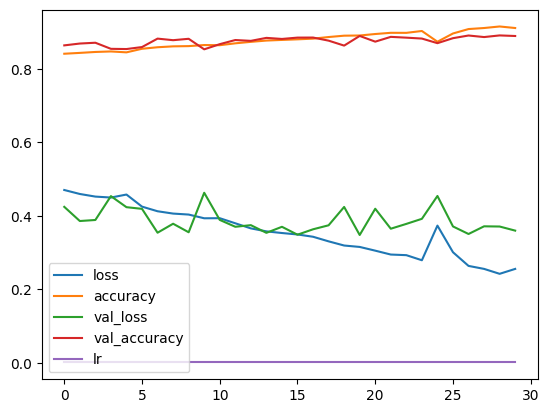

In [ ]:
pd.DataFrame(history_VGG19.history).plot()

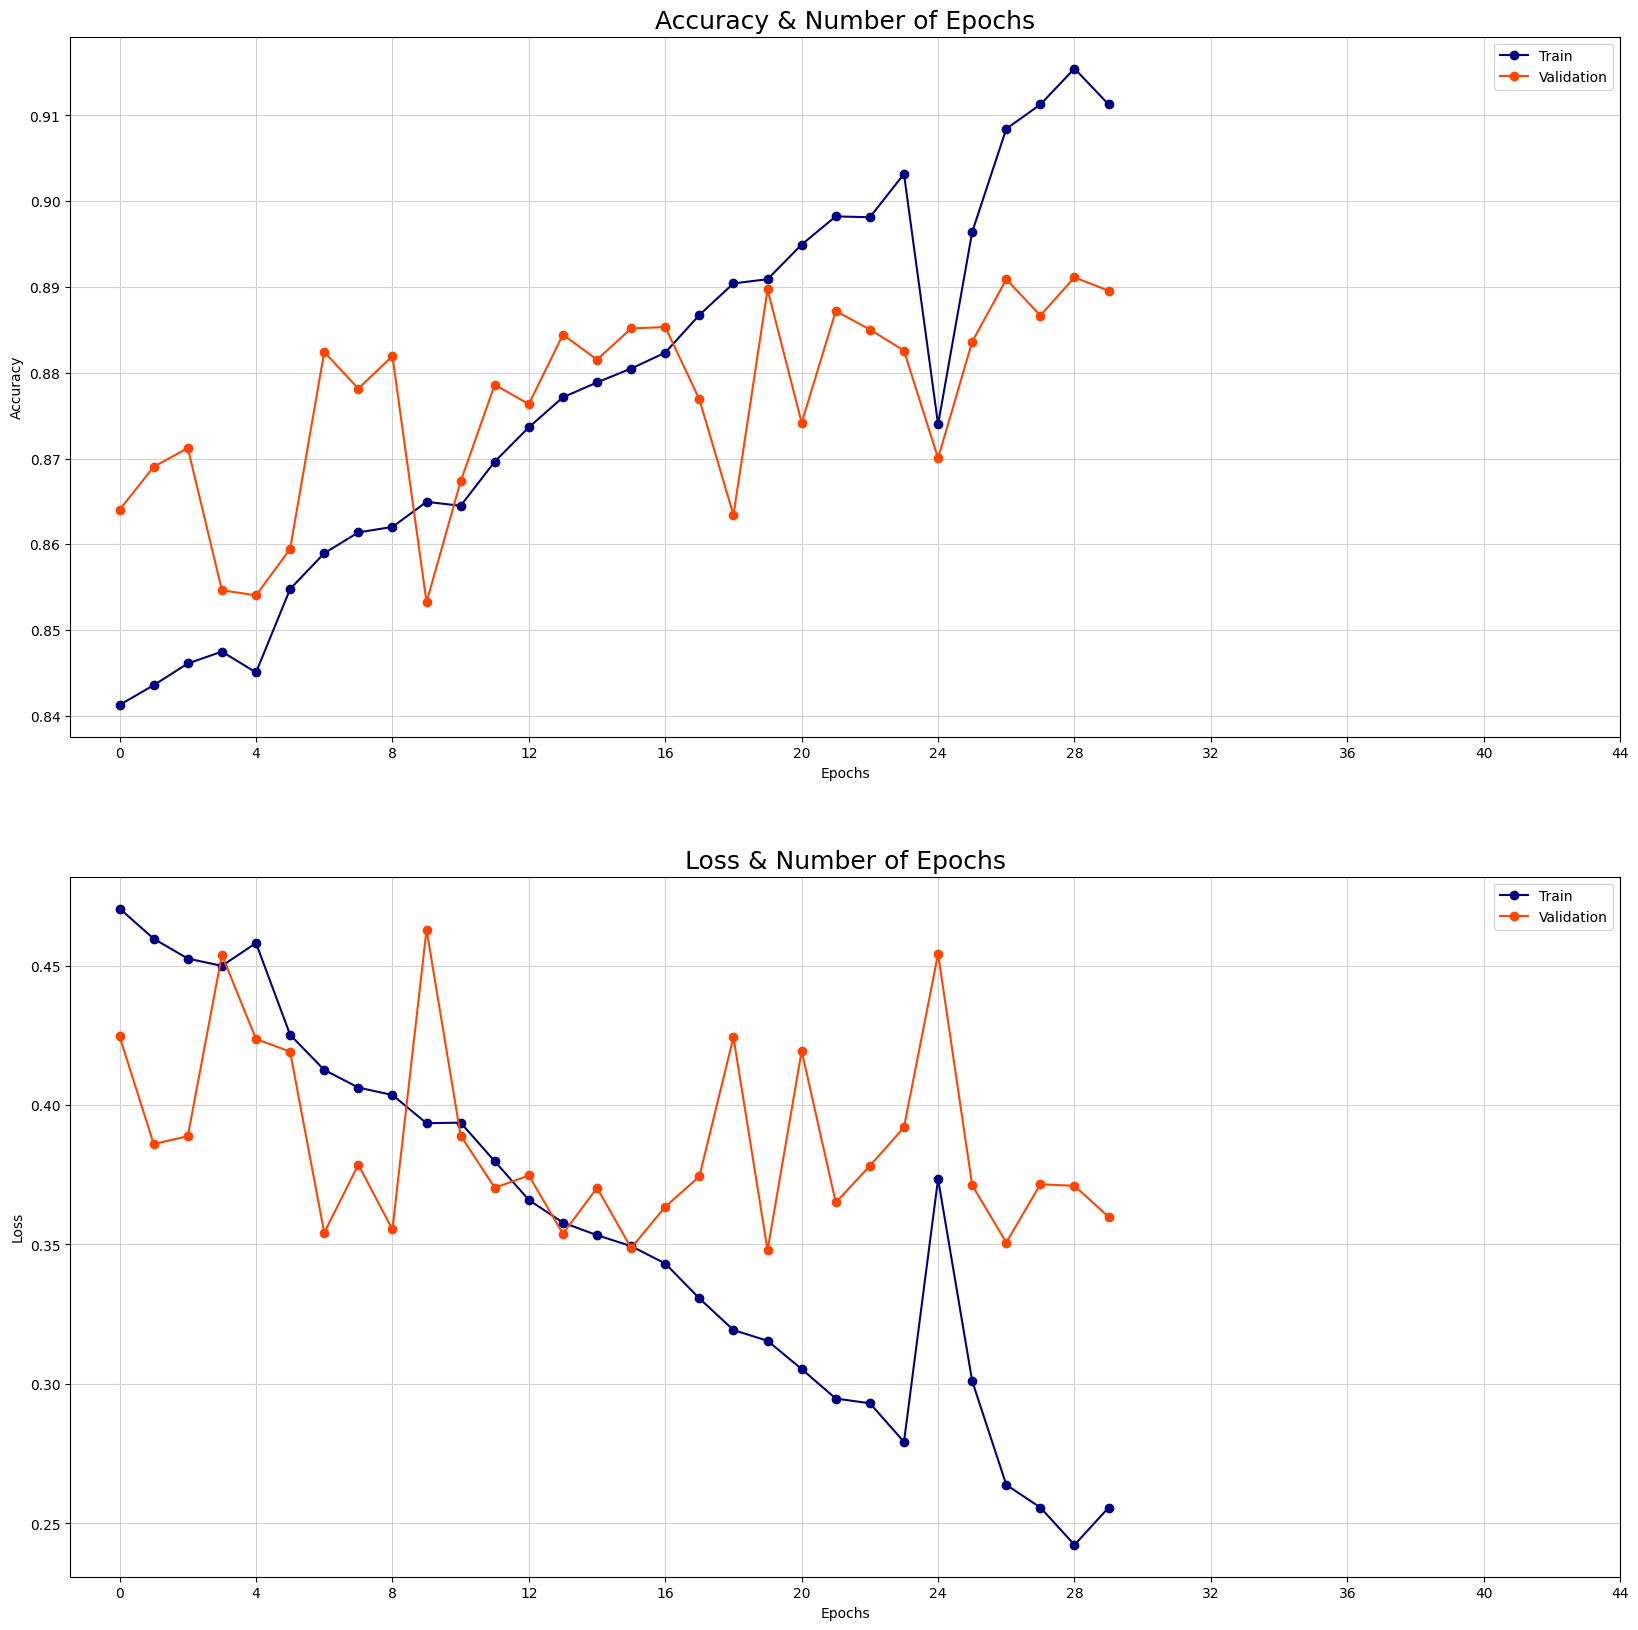

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax = ax.ravel()
metrics_VGG19 = ['Accuracy', 'Loss']

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_VGG19.history[met], 'o-',color= 'navy')
    ax[i].plot(history_VGG19.history['val_' + met], 'o-',color= 'orangered')
    ax[i].set_title('{} & Number of Epochs'.format(metrics_VGG19[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics_VGG19[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")

In [ ]:
y_pred_VGG19=model_VGG19.predict(X_test)

9/9 [==============================] - 1s 97ms/step


In [ ]:
model_VGG19.save("./VGG19_Unet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Densenet-121 U-Net Model

In [ ]:
# Densenet-121 model

def conv_block_Densenet(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def decoder_block_Densenet(inputs, skip_connection_input, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_connection_input])
    x = conv_block_Densenet(x, num_filters)
    return x

In [ ]:
def build_Densenet_unet(input_size,n_classes):
    inputs = layers.Input(input_size)
    Densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

# encoder
    s1 = Densenet.get_layer("input_3").output         # (256 x 256)
    s2 = Densenet.get_layer("conv1/relu").output      # (128 x 128)
    s3 = Densenet.get_layer("pool2_relu").output      # (64 x 64)
    s4 = Densenet.get_layer("pool3_relu").output      # (32 x 32)

    # bridge
    b1 = Densenet.get_layer("pool4_relu").output      # (16 x 16)

    # decoder
    d1 = decoder_block_Densenet(b1, s4, 256)
    d2 = decoder_block_Densenet(d1, s3, 128)
    d3 = decoder_block_Densenet(d2, s2, 64)
    d4 = decoder_block_Densenet(d3, s1, 32)

    # output
    dropout = layers.Dropout(0.3)(d4)
    outputs = layers.Conv2D(n_classes, 1, padding="same", activation="softmax")(dropout)

    model_Densenet = Model(inputs, outputs, name="Densenet-121-UNet")
    return model_Densenet


In [ ]:
model_Densenet = build_Densenet_unet((img_size, img_size, num_channels), num_classes)
model_Densenet.summary()

Model: "Densenet-121-UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 262, 262, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0

In [ ]:
keras.utils.plot_model(
    model_Densenet,
    to_file='Densenet_UNet_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# compile the model
model_Densenet.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

checkpoint_Densenet = ModelCheckpoint("./Densenet_UNet.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping_Densenet = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)
reduce_learningrate_Densenet = ReduceLROnPlateau(monitor='val_acc',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

callbacks_list_Densenet = [early_stopping_Densenet,checkpoint_Densenet,reduce_learningrate_Densenet]

In [ ]:
history_Densenet = model_Densenet.fit(X_train, y_train, batch_size = 16, verbose=1, epochs= 30, validation_data=(X_test, y_test), callbacks = callbacks_list_Densenet)

Epoch 1/30
131/131 [==============================] - ETA: 0s - loss: 0.8684 - accuracy: 0.7349

131/131 [==============================] - 76s 230ms/step - loss: 0.8684 - accuracy: 0.7349 - val_loss: 8.4548 - val_accuracy: 0.1971 - lr: 0.0010
Epoch 2/30
131/131 [==============================] - ETA: 0s - loss: 0.6424 - accuracy: 0.7946

131/131 [==============================] - 24s 187ms/step - loss: 0.6424 - accuracy: 0.7946 - val_loss: 0.8225 - val_accuracy: 0.7215 - lr: 0.0010
Epoch 3/30
131/131 [==============================] - ETA: 0s - loss: 0.5654 - accuracy: 0.8155

131/131 [==============================] - 24s 187ms/step - loss: 0.5654 - accuracy: 0.8155 - val_loss: 0.5109 - val_accuracy: 0.8377 - lr: 0.0010
Epoch 4/30
131/131 [==============================] - ETA: 0s - loss: 0.5151 - accuracy: 0.8297

131/131 [==============================] - 24s 186ms/step - loss: 0.5151 - accuracy: 0.8297 - val_loss: 0.7303 - val_accuracy: 0.7686 - lr: 0.0010
Epoch 5/30
131/131 [==============================] - ETA: 0s - loss: 0.4734 - accuracy: 0.8410

131/131 [==============================] - 24s 187ms/step - loss: 0.4734 - accuracy: 0.8410 - val_loss: 0.4172 - val_accuracy: 0.8621 - lr: 0.0010
Epoch 6/30
131/131 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8462

131/131 [==============================] - 24s 187ms/step - loss: 0.4583 - accuracy: 0.8462 - val_loss: 0.6956 - val_accuracy: 0.7861 - lr: 0.0010
Epoch 7/30
131/131 [==============================] - ETA: 0s - loss: 0.4541 - accuracy: 0.8468

131/131 [==============================] - 24s 187ms/step - loss: 0.4541 - accuracy: 0.8468 - val_loss: 0.3759 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 8/30
131/131 [==============================] - ETA: 0s - loss: 0.4551 - accuracy: 0.8479

131/131 [==============================] - 24s 187ms/step - loss: 0.4551 - accuracy: 0.8479 - val_loss: 0.6390 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 9/30
131/131 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.8541

131/131 [==============================] - 24s 186ms/step - loss: 0.4340 - accuracy: 0.8541 - val_loss: 0.5404 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 10/30
131/131 [==============================] - ETA: 0s - loss: 0.4124 - accuracy: 0.8592

131/131 [==============================] - 24s 187ms/step - loss: 0.4124 - accuracy: 0.8592 - val_loss: 0.5128 - val_accuracy: 0.8186 - lr: 0.0010
Epoch 11/30
131/131 [==============================] - ETA: 0s - loss: 0.3741 - accuracy: 0.8712

131/131 [==============================] - 24s 187ms/step - loss: 0.3741 - accuracy: 0.8712 - val_loss: 0.3543 - val_accuracy: 0.8803 - lr: 0.0010
Epoch 12/30
131/131 [==============================] - ETA: 0s - loss: 0.3609 - accuracy: 0.8762

131/131 [==============================] - 24s 187ms/step - loss: 0.3609 - accuracy: 0.8762 - val_loss: 0.3523 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 13/30
131/131 [==============================] - ETA: 0s - loss: 0.3606 - accuracy: 0.8767

131/131 [==============================] - 24s 187ms/step - loss: 0.3606 - accuracy: 0.8767 - val_loss: 0.3949 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 14/30
131/131 [==============================] - ETA: 0s - loss: 0.3347 - accuracy: 0.8845

131/131 [==============================] - 24s 187ms/step - loss: 0.3347 - accuracy: 0.8845 - val_loss: 0.4122 - val_accuracy: 0.8665 - lr: 0.0010
Epoch 15/30
131/131 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8844

131/131 [==============================] - 24s 187ms/step - loss: 0.3342 - accuracy: 0.8844 - val_loss: 0.5346 - val_accuracy: 0.8293 - lr: 0.0010
Epoch 16/30
131/131 [==============================] - ETA: 0s - loss: 0.3315 - accuracy: 0.8858

131/131 [==============================] - 24s 187ms/step - loss: 0.3315 - accuracy: 0.8858 - val_loss: 0.3668 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 17/30
131/131 [==============================] - ETA: 0s - loss: 0.3103 - accuracy: 0.8925

131/131 [==============================] - 24s 187ms/step - loss: 0.3103 - accuracy: 0.8925 - val_loss: 0.3412 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 18/30
131/131 [==============================] - ETA: 0s - loss: 0.2868 - accuracy: 0.9006

131/131 [==============================] - 24s 187ms/step - loss: 0.2868 - accuracy: 0.9006 - val_loss: 0.4139 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 19/30
131/131 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.8977

131/131 [==============================] - 24s 187ms/step - loss: 0.2944 - accuracy: 0.8977 - val_loss: 0.3669 - val_accuracy: 0.8826 - lr: 0.0010
Epoch 20/30
131/131 [==============================] - ETA: 0s - loss: 0.2563 - accuracy: 0.9109

131/131 [==============================] - 24s 187ms/step - loss: 0.2563 - accuracy: 0.9109 - val_loss: 0.4412 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 21/30
131/131 [==============================] - ETA: 0s - loss: 0.2830 - accuracy: 0.9019

131/131 [==============================] - 25s 187ms/step - loss: 0.2830 - accuracy: 0.9019 - val_loss: 0.4106 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 22/30
131/131 [==============================] - ETA: 0s - loss: 0.2503 - accuracy: 0.9124

131/131 [==============================] - 25s 188ms/step - loss: 0.2503 - accuracy: 0.9124 - val_loss: 0.3617 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 23/30
131/131 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.9091

131/131 [==============================] - 25s 187ms/step - loss: 0.2585 - accuracy: 0.9091 - val_loss: 0.3920 - val_accuracy: 0.8693 - lr: 0.0010
Epoch 24/30
131/131 [==============================] - ETA: 0s - loss: 0.2440 - accuracy: 0.9141

131/131 [==============================] - 24s 187ms/step - loss: 0.2440 - accuracy: 0.9141 - val_loss: 0.3755 - val_accuracy: 0.8865 - lr: 0.0010
Epoch 25/30
131/131 [==============================] - ETA: 0s - loss: 0.2167 - accuracy: 0.9233

131/131 [==============================] - 25s 187ms/step - loss: 0.2167 - accuracy: 0.9233 - val_loss: 0.3573 - val_accuracy: 0.8882 - lr: 0.0010
Epoch 26/30
131/131 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.9264

131/131 [==============================] - 24s 187ms/step - loss: 0.2058 - accuracy: 0.9264 - val_loss: 0.3613 - val_accuracy: 0.8979 - lr: 0.0010
Epoch 27/30
131/131 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.9292

131/131 [==============================] - 24s 187ms/step - loss: 0.1978 - accuracy: 0.9292 - val_loss: 0.3821 - val_accuracy: 0.8914 - lr: 0.0010
Epoch 28/30
131/131 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.9316

131/131 [==============================] - 25s 188ms/step - loss: 0.1915 - accuracy: 0.9316 - val_loss: 0.3573 - val_accuracy: 0.8961 - lr: 0.0010
Epoch 29/30
131/131 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9353

131/131 [==============================] - 24s 187ms/step - loss: 0.1792 - accuracy: 0.9353 - val_loss: 0.4009 - val_accuracy: 0.8868 - lr: 0.0010
Epoch 30/30
131/131 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9360

131/131 [==============================] - 25s 187ms/step - loss: 0.1768 - accuracy: 0.9360 - val_loss: 0.3906 - val_accuracy: 0.8905 - lr: 0.0010


In [ ]:
df_result_Densenet = pd.DataFrame(history_Densenet.history)
df_result_Densenet

loss  accuracy  val_loss  val_accuracy     lr
0   0.868420  0.734889  8.454752      0.197131  0.001
1   0.642447  0.794559  0.822486      0.721514  0.001
2   0.565375  0.815506  0.510915      0.837680  0.001
3   0.515078  0.829717  0.730287      0.768561  0.001
4   0.473405  0.840974  0.417206      0.862150  0.001
5   0.458310  0.846213  0.695639      0.786138  0.001
6   0.454064  0.846792  0.375869      0.872243  0.001
7   0.455075  0.847854  0.639038      0.798855  0.001
8   0.434015  0.854074  0.540442      0.835874  0.001
9   0.412358  0.859230  0.512847      0.818600  0.001
10  0.374083  0.871219  0.354253      0.880264  0.001
11  0.360867  0.876160  0.352274      0.882987  0.001
12  0.360601  0.876659  0.394863      0.874998  0.001
13  0.334746  0.884524  0.412183      0.866521  0.001
14  0.334169  0.884400  0.534635      0.829255  0.001
15  0.331548  0.885787  0.366755      0.883220  0.001
16  0.310255  0.892510  0.341236      0.888395  0.001
17  0.286805  0.900583  0.413865      0.867895  0.001
18  0.294445  0.897745  0.366875      0.882582  0.001
19  0.256308  0.910882  0.441194      0.864397  0.001
20  0.282970  0.901865  0.410607      0.878703  0.001
21  0.250316  0.912434  0.361689      0.892337  0.001
22  0.258459  0.909121  0.392016      0.869271  0.001
23  0.243982  0.914108  0.375508      0.886539  0.001
24  0.216666  0.923342  0.357290      0.888210  0.001
25  0.205789  0.926423  0.361250      0.897855  0.001
26  0.197840  0.929159  0.382143      0.891386  0.001
27  0.191488  0.931561  0.357345      0.896110  0.001
28  0.179213  0.935299  0.400941      0.886833  0.001
29  0.176763  0.936010  0.390579      0.890517  0.001

In [ ]:
# evalute model
loss_Densenet,acc_Densenet= model_Densenet.evaluate(X_test, y_test, verbose=1)
print("accuracy:", acc_Densenet)

9/9 [==============================] - 3s 84ms/step - loss: 0.3906 - accuracy: 0.8905
accuracy: 0.8905166387557983


<Axes: >

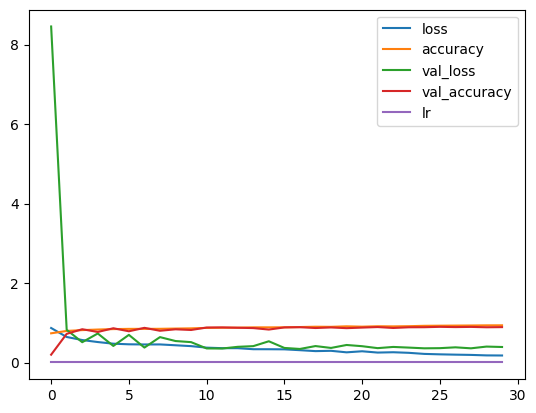

In [ ]:
pd.DataFrame(history_Densenet.history).plot()

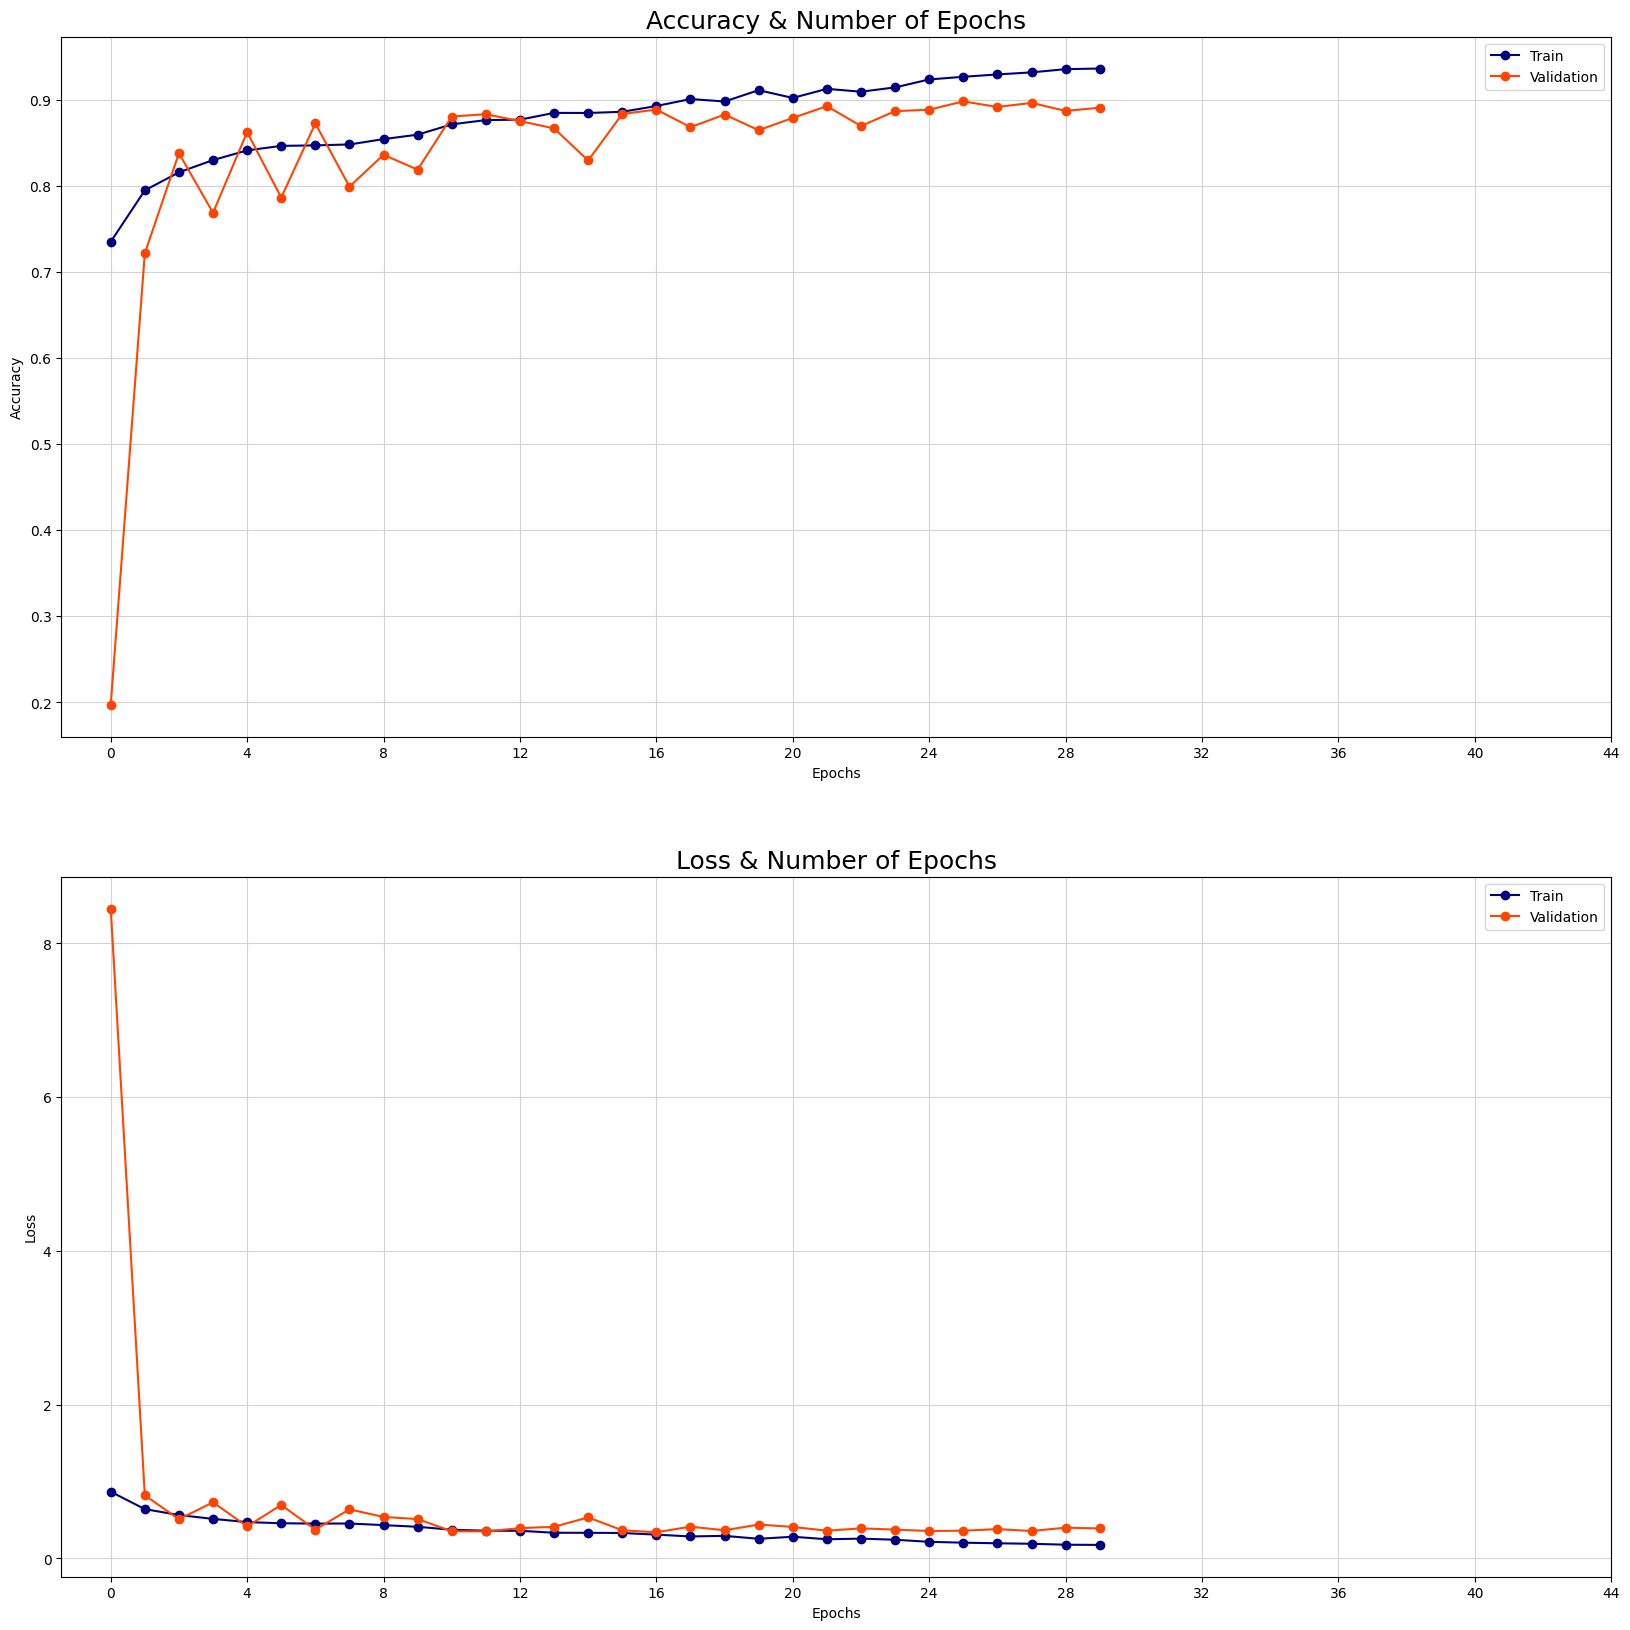

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax = ax.ravel()
metrics_Densenet = ['Accuracy', 'Loss']

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_Densenet.history[met], 'o-',color= 'navy')
    ax[i].plot(history_Densenet.history['val_' + met], 'o-',color= 'orangered')
    ax[i].set_title('{} & Number of Epochs'.format(metrics_Densenet[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics_Densenet[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")

In [ ]:
y_pred_Densenet=model_Densenet.predict(X_test)

9/9 [==============================] - 3s 75ms/step


In [ ]:
model_Densenet.save("Densenet_Unet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# EfficientnetB0 U-Net Model

In [ ]:
# EfficientnetB0 model

def conv_block_Efficientnet(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def decoder_block_Efficientnet(inputs, skip_connection_input, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_connection_input])
    x = conv_block_Densenet(x, num_filters)
    return x

In [ ]:
def Efficientnet_unet(input_size,n_classes):
    inputs = layers.Input(input_size)
    Efficientnet = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)

    # encoder
    s1 = Efficientnet.get_layer("input_4").output                        # (256 x 256)
    s2 = Efficientnet.get_layer("block2a_expand_activation").output      # (128 x 128)
    s3 = Efficientnet.get_layer("block3a_expand_activation").output      # (64 x 64)
    s4 = Efficientnet.get_layer("block4a_expand_activation").output      # (32 x 32)

    # bridge
    b1 = Efficientnet.get_layer("block6a_expand_activation").output      # (16 x 16)

    # decoder
    d1 = decoder_block_Efficientnet(b1, s4, 256)
    d2 = decoder_block_Efficientnet(d1, s3, 128)
    d3 = decoder_block_Efficientnet(d2, s2, 64)
    d4 = decoder_block_Efficientnet(d3, s1, 32)

    # output
    dropout = layers.Dropout(0.3)(d4)
    outputs = layers.Conv2D(n_classes, 1, padding="same", activation="softmax")(dropout)

    model_Efficientnet = Model(inputs, outputs, name="EfficientnetB0-UNet")
    return model_Efficientnet

In [ ]:
model_Efficientnet = Efficientnet_unet((img_size, img_size, num_channels), num_classes)
model_Efficientnet.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "EfficientnetB0-UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (R

In [ ]:
keras.utils.plot_model(
    model_Efficientnet,
    to_file='EfficientnetB0-UNet_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# compile the model
model_Efficientnet.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

checkpoint_Efficientnet = ModelCheckpoint("./Efficientnet_UNet.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping_Efficientnet = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)
reduce_learningrate_Efficientnet = ReduceLROnPlateau(monitor='val_acc',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

callbacks_list_Efficientnet = [early_stopping_Efficientnet,checkpoint_Efficientnet,reduce_learningrate_Efficientnet]

In [ ]:
history_Efficientnet = model_Efficientnet.fit(X_train, y_train, batch_size = 16, verbose=1, epochs= 30, validation_data=(X_test, y_test), callbacks = callbacks_list_Efficientnet)

Epoch 1/30
131/131 [==============================] - ETA: 0s - loss: 0.7930 - accuracy: 0.7509

131/131 [==============================] - 58s 190ms/step - loss: 0.7930 - accuracy: 0.7509 - val_loss: 48.9692 - val_accuracy: 0.1314 - lr: 0.0010
Epoch 2/30
131/131 [==============================] - ETA: 0s - loss: 0.5500 - accuracy: 0.8229

131/131 [==============================] - 20s 154ms/step - loss: 0.5500 - accuracy: 0.8229 - val_loss: 8.3771 - val_accuracy: 0.1482 - lr: 0.0010
Epoch 3/30
131/131 [==============================] - ETA: 0s - loss: 0.4935 - accuracy: 0.8373

131/131 [==============================] - 20s 154ms/step - loss: 0.4935 - accuracy: 0.8373 - val_loss: 44.0889 - val_accuracy: 0.1319 - lr: 0.0010
Epoch 4/30
131/131 [==============================] - ETA: 0s - loss: 0.4597 - accuracy: 0.8463

131/131 [==============================] - 20s 155ms/step - loss: 0.4597 - accuracy: 0.8463 - val_loss: 63.9454 - val_accuracy: 0.1317 - lr: 0.0010
Epoch 5/30
131/131 [==============================] - ETA: 0s - loss: 0.4321 - accuracy: 0.8557

131/131 [==============================] - 20s 154ms/step - loss: 0.4321 - accuracy: 0.8557 - val_loss: 33.7564 - val_accuracy: 0.1285 - lr: 0.0010
Epoch 6/30
131/131 [==============================] - ETA: 0s - loss: 0.3990 - accuracy: 0.8666

131/131 [==============================] - 20s 154ms/step - loss: 0.3990 - accuracy: 0.8666 - val_loss: 55.4303 - val_accuracy: 0.1314 - lr: 0.0010
Epoch 7/30
131/131 [==============================] - ETA: 0s - loss: 0.3723 - accuracy: 0.8749

131/131 [==============================] - 20s 154ms/step - loss: 0.3723 - accuracy: 0.8749 - val_loss: 24.4386 - val_accuracy: 0.1484 - lr: 0.0010
Epoch 8/30
131/131 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.8841

131/131 [==============================] - 20s 154ms/step - loss: 0.3455 - accuracy: 0.8841 - val_loss: 44.8021 - val_accuracy: 0.1313 - lr: 0.0010
Epoch 9/30
131/131 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8915

131/131 [==============================] - 20s 154ms/step - loss: 0.3216 - accuracy: 0.8915 - val_loss: 30.3111 - val_accuracy: 0.1460 - lr: 0.0010
Epoch 10/30
131/131 [==============================] - ETA: 0s - loss: 0.3156 - accuracy: 0.8936

131/131 [==============================] - 20s 154ms/step - loss: 0.3156 - accuracy: 0.8936 - val_loss: 10.9356 - val_accuracy: 0.1394 - lr: 0.0010
Epoch 11/30
131/131 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.9017

131/131 [==============================] - 20s 154ms/step - loss: 0.2907 - accuracy: 0.9017 - val_loss: 35.6437 - val_accuracy: 0.1300 - lr: 0.0010
Epoch 12/30
131/131 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.9077

131/131 [==============================] - 20s 154ms/step - loss: 0.2708 - accuracy: 0.9077 - val_loss: 8.5835 - val_accuracy: 0.1747 - lr: 0.0010
Epoch 13/30
131/131 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.9084

131/131 [==============================] - 20s 154ms/step - loss: 0.2672 - accuracy: 0.9084 - val_loss: 20.9731 - val_accuracy: 0.1511 - lr: 0.0010
Epoch 14/30
131/131 [==============================] - ETA: 0s - loss: 0.2449 - accuracy: 0.9157

131/131 [==============================] - 20s 154ms/step - loss: 0.2449 - accuracy: 0.9157 - val_loss: 13.3782 - val_accuracy: 0.1390 - lr: 0.0010
Epoch 15/30
131/131 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.9139

131/131 [==============================] - 20s 154ms/step - loss: 0.2516 - accuracy: 0.9139 - val_loss: 46.0690 - val_accuracy: 0.1160 - lr: 0.0010
Epoch 16/30
131/131 [==============================] - ETA: 0s - loss: 0.2441 - accuracy: 0.9154

131/131 [==============================] - 20s 154ms/step - loss: 0.2441 - accuracy: 0.9154 - val_loss: 5.2888 - val_accuracy: 0.2223 - lr: 0.0010
Epoch 17/30
131/131 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.9200

131/131 [==============================] - 20s 154ms/step - loss: 0.2289 - accuracy: 0.9200 - val_loss: 36.6170 - val_accuracy: 0.1245 - lr: 0.0010
Epoch 18/30
131/131 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9244

131/131 [==============================] - 20s 154ms/step - loss: 0.2161 - accuracy: 0.9244 - val_loss: 6.2620 - val_accuracy: 0.3593 - lr: 0.0010
Epoch 19/30
131/131 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.9264

131/131 [==============================] - 20s 154ms/step - loss: 0.2093 - accuracy: 0.9264 - val_loss: 10.2279 - val_accuracy: 0.2347 - lr: 0.0010
Epoch 20/30
131/131 [==============================] - ETA: 0s - loss: 0.2009 - accuracy: 0.9284

131/131 [==============================] - 20s 154ms/step - loss: 0.2009 - accuracy: 0.9284 - val_loss: 8.0200 - val_accuracy: 0.2312 - lr: 0.0010
Epoch 21/30
131/131 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9313

131/131 [==============================] - 20s 154ms/step - loss: 0.1924 - accuracy: 0.9313 - val_loss: 0.9781 - val_accuracy: 0.7274 - lr: 0.0010
Epoch 22/30
131/131 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9322

131/131 [==============================] - 20s 154ms/step - loss: 0.1897 - accuracy: 0.9322 - val_loss: 13.7386 - val_accuracy: 0.1217 - lr: 0.0010
Epoch 23/30
131/131 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9287

131/131 [==============================] - 20s 154ms/step - loss: 0.2012 - accuracy: 0.9287 - val_loss: 3.5773 - val_accuracy: 0.3903 - lr: 0.0010
Epoch 24/30
131/131 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9339

131/131 [==============================] - 20s 154ms/step - loss: 0.1847 - accuracy: 0.9339 - val_loss: 9.1438 - val_accuracy: 0.3889 - lr: 0.0010
Epoch 25/30
131/131 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9353

131/131 [==============================] - 20s 154ms/step - loss: 0.1802 - accuracy: 0.9353 - val_loss: 18.3573 - val_accuracy: 0.3148 - lr: 0.0010
Epoch 26/30
131/131 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9395

131/131 [==============================] - 20s 153ms/step - loss: 0.1677 - accuracy: 0.9395 - val_loss: 34.9065 - val_accuracy: 0.1336 - lr: 0.0010
Epoch 27/30
131/131 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9419

131/131 [==============================] - 20s 154ms/step - loss: 0.1599 - accuracy: 0.9419 - val_loss: 3.3023 - val_accuracy: 0.4289 - lr: 0.0010
Epoch 28/30
131/131 [==============================] - ETA: 0s - loss: 0.1635 - accuracy: 0.9408

131/131 [==============================] - 20s 154ms/step - loss: 0.1635 - accuracy: 0.9408 - val_loss: 6.7665 - val_accuracy: 0.2497 - lr: 0.0010
Epoch 29/30
131/131 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.9432

131/131 [==============================] - 20s 154ms/step - loss: 0.1561 - accuracy: 0.9432 - val_loss: 39.5398 - val_accuracy: 0.1491 - lr: 0.0010
Epoch 30/30
131/131 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9380

131/131 [==============================] - 20s 154ms/step - loss: 0.1731 - accuracy: 0.9380 - val_loss: 31.3209 - val_accuracy: 0.1401 - lr: 0.0010


In [ ]:
df_result_Efficientnet = pd.DataFrame(history_Efficientnet.history)
df_result_Efficientnet

loss  accuracy   val_loss  val_accuracy     lr
0   0.792990  0.750886  48.969238      0.131408  0.001
1   0.550041  0.822940   8.377142      0.148164  0.001
2   0.493453  0.837318  44.088852      0.131866  0.001
3   0.459746  0.846294  63.945412      0.131710  0.001
4   0.432093  0.855688  33.756390      0.128479  0.001
5   0.398951  0.866570  55.430283      0.131371  0.001
6   0.372300  0.874876  24.438637      0.148382  0.001
7   0.345541  0.884099  44.802109      0.131315  0.001
8   0.321627  0.891518  30.311054      0.146002  0.001
9   0.315608  0.893580  10.935609      0.139400  0.001
10  0.290663  0.901695  35.643658      0.130022  0.001
11  0.270814  0.907671   8.583532      0.174727  0.001
12  0.267207  0.908437  20.973124      0.151059  0.001
13  0.244950  0.915654  13.378152      0.138974  0.001
14  0.251558  0.913866  46.068996      0.116041  0.001
15  0.244109  0.915364   5.288768      0.222344  0.001
16  0.228908  0.920028  36.616966      0.124455  0.001
17  0.216108  0.924434   6.262009      0.359292  0.001
18  0.209257  0.926398  10.227942      0.234744  0.001
19  0.200886  0.928441   8.020032      0.231172  0.001
20  0.192378  0.931315   0.978060      0.727375  0.001
21  0.189710  0.932196  13.738567      0.121713  0.001
22  0.201171  0.928692   3.577256      0.390336  0.001
23  0.184672  0.933915   9.143782      0.388885  0.001
24  0.180166  0.935300  18.357325      0.314751  0.001
25  0.167690  0.939499  34.906528      0.133558  0.001
26  0.159909  0.941936   3.302278      0.428935  0.001
27  0.163534  0.940803   6.766459      0.249729  0.001
28  0.156133  0.943214  39.539810      0.149136  0.001
29  0.173057  0.938025  31.320946      0.140125  0.001

In [ ]:
# evalute model
loss_Efficientnet,acc_Efficientnet= model_Efficientnet.evaluate(X_test, y_test, verbose=1)
print("accuracy:", acc_Efficientnet)

9/9 [==============================] - 2s 71ms/step - loss: 31.3209 - accuracy: 0.1401
accuracy: 0.14012543857097626


# Attention U-Net

In [14]:
# Attention U-net Model
def conv_block_Attention_unet(x, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def encoder_block_Attention_unet(x, num_filters):
    x = conv_block_Attention_unet(x, num_filters)
    p = layers.MaxPool2D((2, 2))(x)
    return x, p

In [15]:
def attention_gate(g, s, num_filters):
    Wg = layers.Conv2D(num_filters, 1, padding="same")(g)
    Wg = layers.BatchNormalization()(Wg)

    Ws = layers.Conv2D(num_filters, 1, padding="same")(s)
    Ws = layers.BatchNormalization()(Ws)

    out = layers.Activation("relu")(Wg + Ws)
    out = layers.Conv2D(num_filters, 1, padding="same")(out)
    out = layers.Activation("sigmoid")(out)

    return out * s

In [16]:
def decoder_block_Attention_unet(x, s, num_filters):
    x = layers.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = layers.Concatenate()([x, s])
    x = conv_block_Attention_unet(x, num_filters)
    return x

In [17]:
def attention_unet(input_size,n_classes):
    inputs = layers.Input(input_size)

    s1, p1 = encoder_block_Attention_unet(inputs, 64)
    s2, p2 = encoder_block_Attention_unet(p1, 128)
    s3, p3 = encoder_block_Attention_unet(p2, 256)

    b1 = conv_block_Attention_unet(p3, 512)

    d1 = decoder_block_Attention_unet(b1, s3, 256)
    d2 = decoder_block_Attention_unet(d1, s2, 128)
    d3 = decoder_block_Attention_unet(d2, s1, 64)

    outputs = layers.Conv2D(filters = n_classes, kernel_size = (1,1), padding="same", activation="softmax")(d3)
    Attention_unet_model = Model(inputs, outputs, name="Attention-UNET")
    return Attention_unet_model

In [18]:
Attention_unet_model = attention_unet((img_size, img_size, num_channels), num_classes)
Attention_unet_model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normaliza

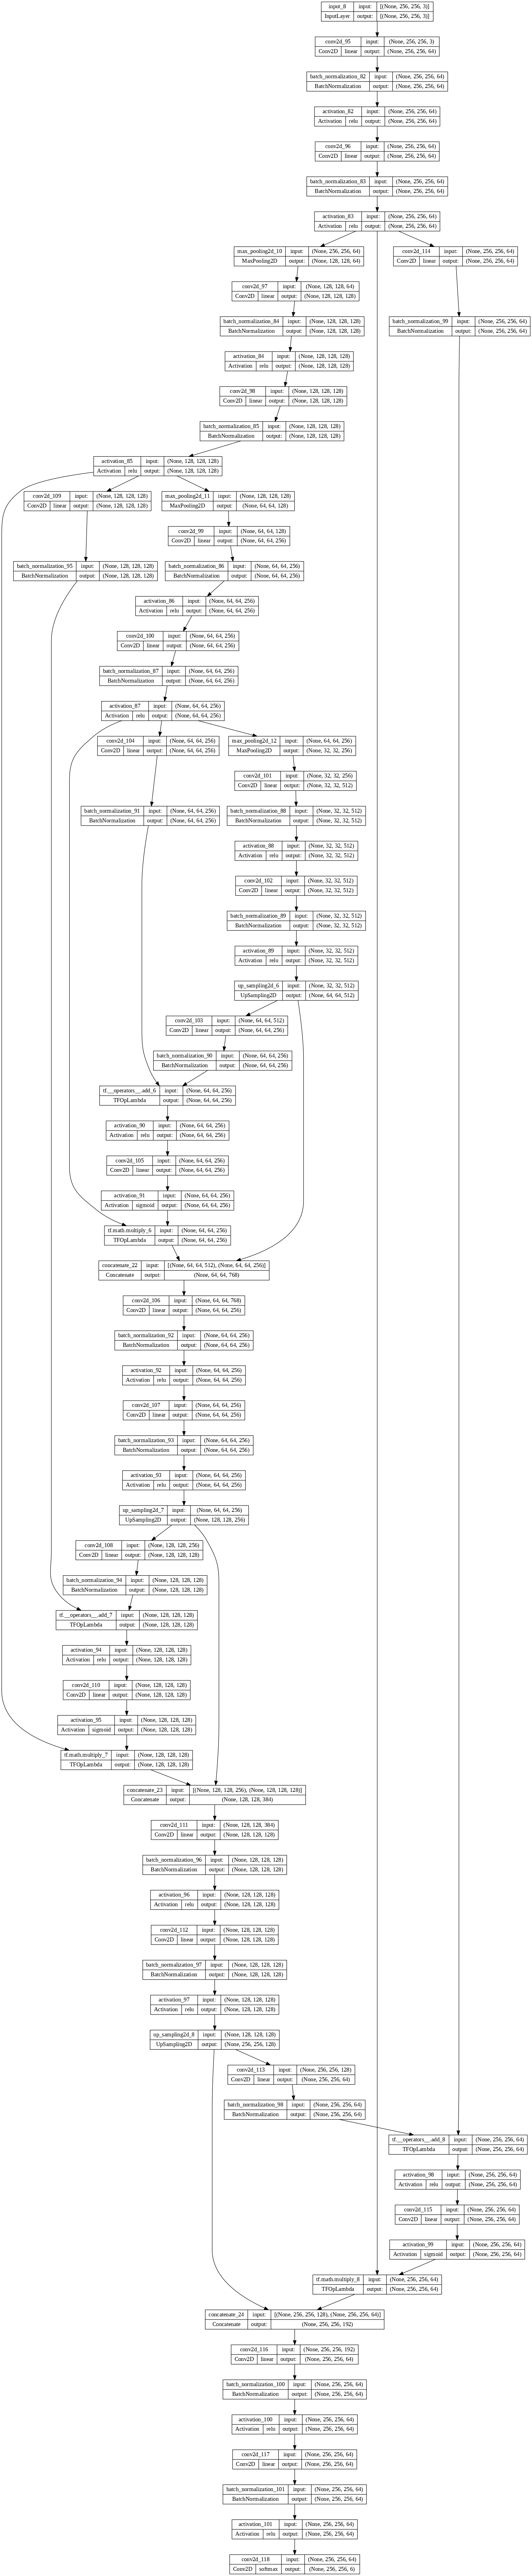

In [ ]:
keras.utils.plot_model(
    Attention_unet_model,
    to_file='Attention_UNet_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [19]:
# compile the model
Attention_unet_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

checkpoint_Attention_unet = ModelCheckpoint("./Attention_UNet.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping_Attention_unet = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)
reduce_learningrate_Attention_unet = ReduceLROnPlateau(monitor='val_acc',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

callbacks_list_Attention_unet = [early_stopping_Attention_unet,checkpoint_Attention_unet,reduce_learningrate_Attention_unet]

In [20]:
history_Attention_unet = Attention_unet_model.fit(X_train, y_train, batch_size = 16, verbose=1, epochs= 30, validation_data=(X_test, y_test), callbacks = callbacks_list_Attention_unet)

Epoch 1/30
131/131 [==============================] - ETA: 0s - loss: 0.8569 - accuracy: 0.7224

131/131 [==============================] - 63s 281ms/step - loss: 0.8569 - accuracy: 0.7224 - val_loss: 1.3652 - val_accuracy: 0.5845 - lr: 0.0010
Epoch 2/30
131/131 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.7654

131/131 [==============================] - 21s 160ms/step - loss: 0.6836 - accuracy: 0.7654 - val_loss: 1.3609 - val_accuracy: 0.5757 - lr: 0.0010
Epoch 3/30
131/131 [==============================] - ETA: 0s - loss: 0.6112 - accuracy: 0.7892

131/131 [==============================] - 21s 160ms/step - loss: 0.6112 - accuracy: 0.7892 - val_loss: 1.4102 - val_accuracy: 0.6262 - lr: 0.0010
Epoch 4/30
131/131 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.7948

131/131 [==============================] - 21s 160ms/step - loss: 0.5940 - accuracy: 0.7948 - val_loss: 0.9169 - val_accuracy: 0.7374 - lr: 0.0010
Epoch 5/30
131/131 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.8051

131/131 [==============================] - 21s 160ms/step - loss: 0.5662 - accuracy: 0.8051 - val_loss: 1.1051 - val_accuracy: 0.6772 - lr: 0.0010
Epoch 6/30
131/131 [==============================] - ETA: 0s - loss: 0.5566 - accuracy: 0.8085

131/131 [==============================] - 21s 160ms/step - loss: 0.5566 - accuracy: 0.8085 - val_loss: 0.6578 - val_accuracy: 0.8183 - lr: 0.0010
Epoch 7/30
131/131 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.8198

131/131 [==============================] - 21s 160ms/step - loss: 0.5231 - accuracy: 0.8198 - val_loss: 0.8687 - val_accuracy: 0.6678 - lr: 0.0010
Epoch 8/30
131/131 [==============================] - ETA: 0s - loss: 0.5126 - accuracy: 0.8225

131/131 [==============================] - 21s 160ms/step - loss: 0.5126 - accuracy: 0.8225 - val_loss: 0.6116 - val_accuracy: 0.8041 - lr: 0.0010
Epoch 9/30
131/131 [==============================] - ETA: 0s - loss: 0.5011 - accuracy: 0.8269

131/131 [==============================] - 21s 160ms/step - loss: 0.5011 - accuracy: 0.8269 - val_loss: 0.4791 - val_accuracy: 0.8386 - lr: 0.0010
Epoch 10/30
131/131 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.8285

131/131 [==============================] - 21s 160ms/step - loss: 0.4921 - accuracy: 0.8285 - val_loss: 0.6089 - val_accuracy: 0.8064 - lr: 0.0010
Epoch 11/30
131/131 [==============================] - ETA: 0s - loss: 0.4769 - accuracy: 0.8341

131/131 [==============================] - 21s 160ms/step - loss: 0.4769 - accuracy: 0.8341 - val_loss: 0.5153 - val_accuracy: 0.8284 - lr: 0.0010
Epoch 12/30
131/131 [==============================] - ETA: 0s - loss: 0.4777 - accuracy: 0.8332

131/131 [==============================] - 21s 160ms/step - loss: 0.4777 - accuracy: 0.8332 - val_loss: 0.7690 - val_accuracy: 0.7159 - lr: 0.0010
Epoch 13/30
131/131 [==============================] - ETA: 0s - loss: 0.4659 - accuracy: 0.8366

131/131 [==============================] - 21s 160ms/step - loss: 0.4659 - accuracy: 0.8366 - val_loss: 0.5235 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 14/30
131/131 [==============================] - ETA: 0s - loss: 0.4575 - accuracy: 0.8405

131/131 [==============================] - 21s 160ms/step - loss: 0.4575 - accuracy: 0.8405 - val_loss: 0.5163 - val_accuracy: 0.8248 - lr: 0.0010
Epoch 15/30
131/131 [==============================] - ETA: 0s - loss: 0.4516 - accuracy: 0.8421

131/131 [==============================] - 21s 160ms/step - loss: 0.4516 - accuracy: 0.8421 - val_loss: 0.5107 - val_accuracy: 0.8369 - lr: 0.0010
Epoch 16/30
131/131 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.8401

131/131 [==============================] - 21s 160ms/step - loss: 0.4533 - accuracy: 0.8401 - val_loss: 0.5296 - val_accuracy: 0.8146 - lr: 0.0010
Epoch 17/30
131/131 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.8425

131/131 [==============================] - 21s 160ms/step - loss: 0.4474 - accuracy: 0.8425 - val_loss: 0.4297 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 18/30
131/131 [==============================] - ETA: 0s - loss: 0.4266 - accuracy: 0.8487

131/131 [==============================] - 21s 160ms/step - loss: 0.4266 - accuracy: 0.8487 - val_loss: 0.4718 - val_accuracy: 0.8474 - lr: 0.0010
Epoch 19/30
131/131 [==============================] - ETA: 0s - loss: 0.4187 - accuracy: 0.8512

131/131 [==============================] - 21s 160ms/step - loss: 0.4187 - accuracy: 0.8512 - val_loss: 0.4281 - val_accuracy: 0.8597 - lr: 0.0010
Epoch 20/30
131/131 [==============================] - ETA: 0s - loss: 0.4190 - accuracy: 0.8499

131/131 [==============================] - 21s 160ms/step - loss: 0.4190 - accuracy: 0.8499 - val_loss: 0.9718 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 21/30
131/131 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.8511

131/131 [==============================] - 21s 160ms/step - loss: 0.4158 - accuracy: 0.8511 - val_loss: 0.6648 - val_accuracy: 0.7636 - lr: 0.0010
Epoch 22/30
131/131 [==============================] - ETA: 0s - loss: 0.4036 - accuracy: 0.8554

131/131 [==============================] - 21s 160ms/step - loss: 0.4036 - accuracy: 0.8554 - val_loss: 0.4235 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 23/30
131/131 [==============================] - ETA: 0s - loss: 0.4066 - accuracy: 0.8535

131/131 [==============================] - 21s 160ms/step - loss: 0.4066 - accuracy: 0.8535 - val_loss: 0.4599 - val_accuracy: 0.8439 - lr: 0.0010
Epoch 24/30
131/131 [==============================] - ETA: 0s - loss: 0.3990 - accuracy: 0.8571

131/131 [==============================] - 21s 160ms/step - loss: 0.3990 - accuracy: 0.8571 - val_loss: 0.3818 - val_accuracy: 0.8719 - lr: 0.0010
Epoch 25/30
131/131 [==============================] - ETA: 0s - loss: 0.3889 - accuracy: 0.8595

131/131 [==============================] - 21s 160ms/step - loss: 0.3889 - accuracy: 0.8595 - val_loss: 0.3900 - val_accuracy: 0.8724 - lr: 0.0010
Epoch 26/30
131/131 [==============================] - ETA: 0s - loss: 0.3834 - accuracy: 0.8617

131/131 [==============================] - 21s 160ms/step - loss: 0.3834 - accuracy: 0.8617 - val_loss: 0.5360 - val_accuracy: 0.8108 - lr: 0.0010
Epoch 27/30
131/131 [==============================] - ETA: 0s - loss: 0.3857 - accuracy: 0.8609

131/131 [==============================] - 21s 160ms/step - loss: 0.3857 - accuracy: 0.8609 - val_loss: 0.4000 - val_accuracy: 0.8631 - lr: 0.0010
Epoch 28/30
131/131 [==============================] - ETA: 0s - loss: 0.3789 - accuracy: 0.8637

131/131 [==============================] - 21s 160ms/step - loss: 0.3789 - accuracy: 0.8637 - val_loss: 0.3968 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 29/30
131/131 [==============================] - ETA: 0s - loss: 0.3728 - accuracy: 0.8653

131/131 [==============================] - 21s 160ms/step - loss: 0.3728 - accuracy: 0.8653 - val_loss: 0.3719 - val_accuracy: 0.8764 - lr: 0.0010
Epoch 30/30
131/131 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.8595

131/131 [==============================] - 21s 160ms/step - loss: 0.3913 - accuracy: 0.8595 - val_loss: 0.5016 - val_accuracy: 0.8250 - lr: 0.0010


In [21]:
df_Attention_unet = pd.DataFrame(history_Attention_unet.history)
df_Attention_unet

loss  accuracy  val_loss  val_accuracy     lr
0   0.856913  0.722403  1.365241      0.584504  0.001
1   0.683562  0.765357  1.360907      0.575712  0.001
2   0.611207  0.789156  1.410152      0.626172  0.001
3   0.593957  0.794795  0.916943      0.737404  0.001
4   0.566216  0.805131  1.105102      0.677231  0.001
5   0.556597  0.808544  0.657827      0.818256  0.001
6   0.523141  0.819752  0.868731      0.667797  0.001
7   0.512570  0.822532  0.611552      0.804118  0.001
8   0.501060  0.826881  0.479098      0.838612  0.001
9   0.492076  0.828467  0.608913      0.806413  0.001
10  0.476920  0.834118  0.515307      0.828413  0.001
11  0.477744  0.833191  0.769007      0.715932  0.001
12  0.465851  0.836601  0.523537      0.825037  0.001
13  0.457545  0.840505  0.516305      0.824807  0.001
14  0.451578  0.842137  0.510743      0.836931  0.001
15  0.453326  0.840088  0.529625      0.814630  0.001
16  0.447392  0.842527  0.429742      0.860028  0.001
17  0.426587  0.848696  0.471834      0.847373  0.001
18  0.418748  0.851173  0.428077      0.859699  0.001
19  0.418982  0.849931  0.971774      0.656927  0.001
20  0.415808  0.851109  0.664836      0.763569  0.001
21  0.403607  0.855386  0.423487      0.866079  0.001
22  0.406610  0.853452  0.459905      0.843866  0.001
23  0.399018  0.857061  0.381758      0.871933  0.001
24  0.388939  0.859466  0.389971      0.872404  0.001
25  0.383376  0.861697  0.535963      0.810828  0.001
26  0.385707  0.860905  0.400007      0.863066  0.001
27  0.378889  0.863736  0.396818      0.871516  0.001
28  0.372801  0.865345  0.371873      0.876359  0.001
29  0.391298  0.859469  0.501639      0.825042  0.001

In [22]:
# evalute model
loss_Attention_unet,acc_Attention_unet= Attention_unet_model.evaluate(X_test, y_test, verbose=1)
print("accuracy:", acc_Attention_unet)

9/9 [==============================] - 12s 90ms/step - loss: 0.5016 - accuracy: 0.8250
accuracy: 0.825042188167572


<Axes: >

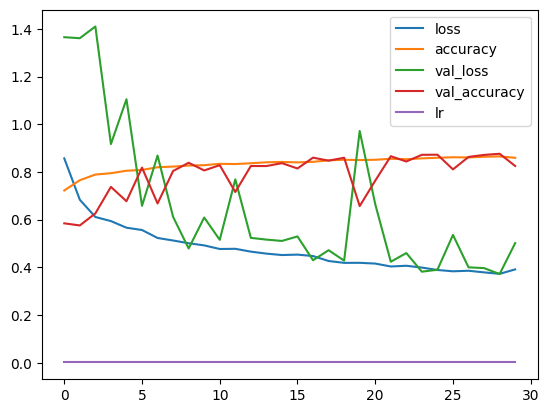

In [23]:
pd.DataFrame(history_Attention_unet.history).plot()

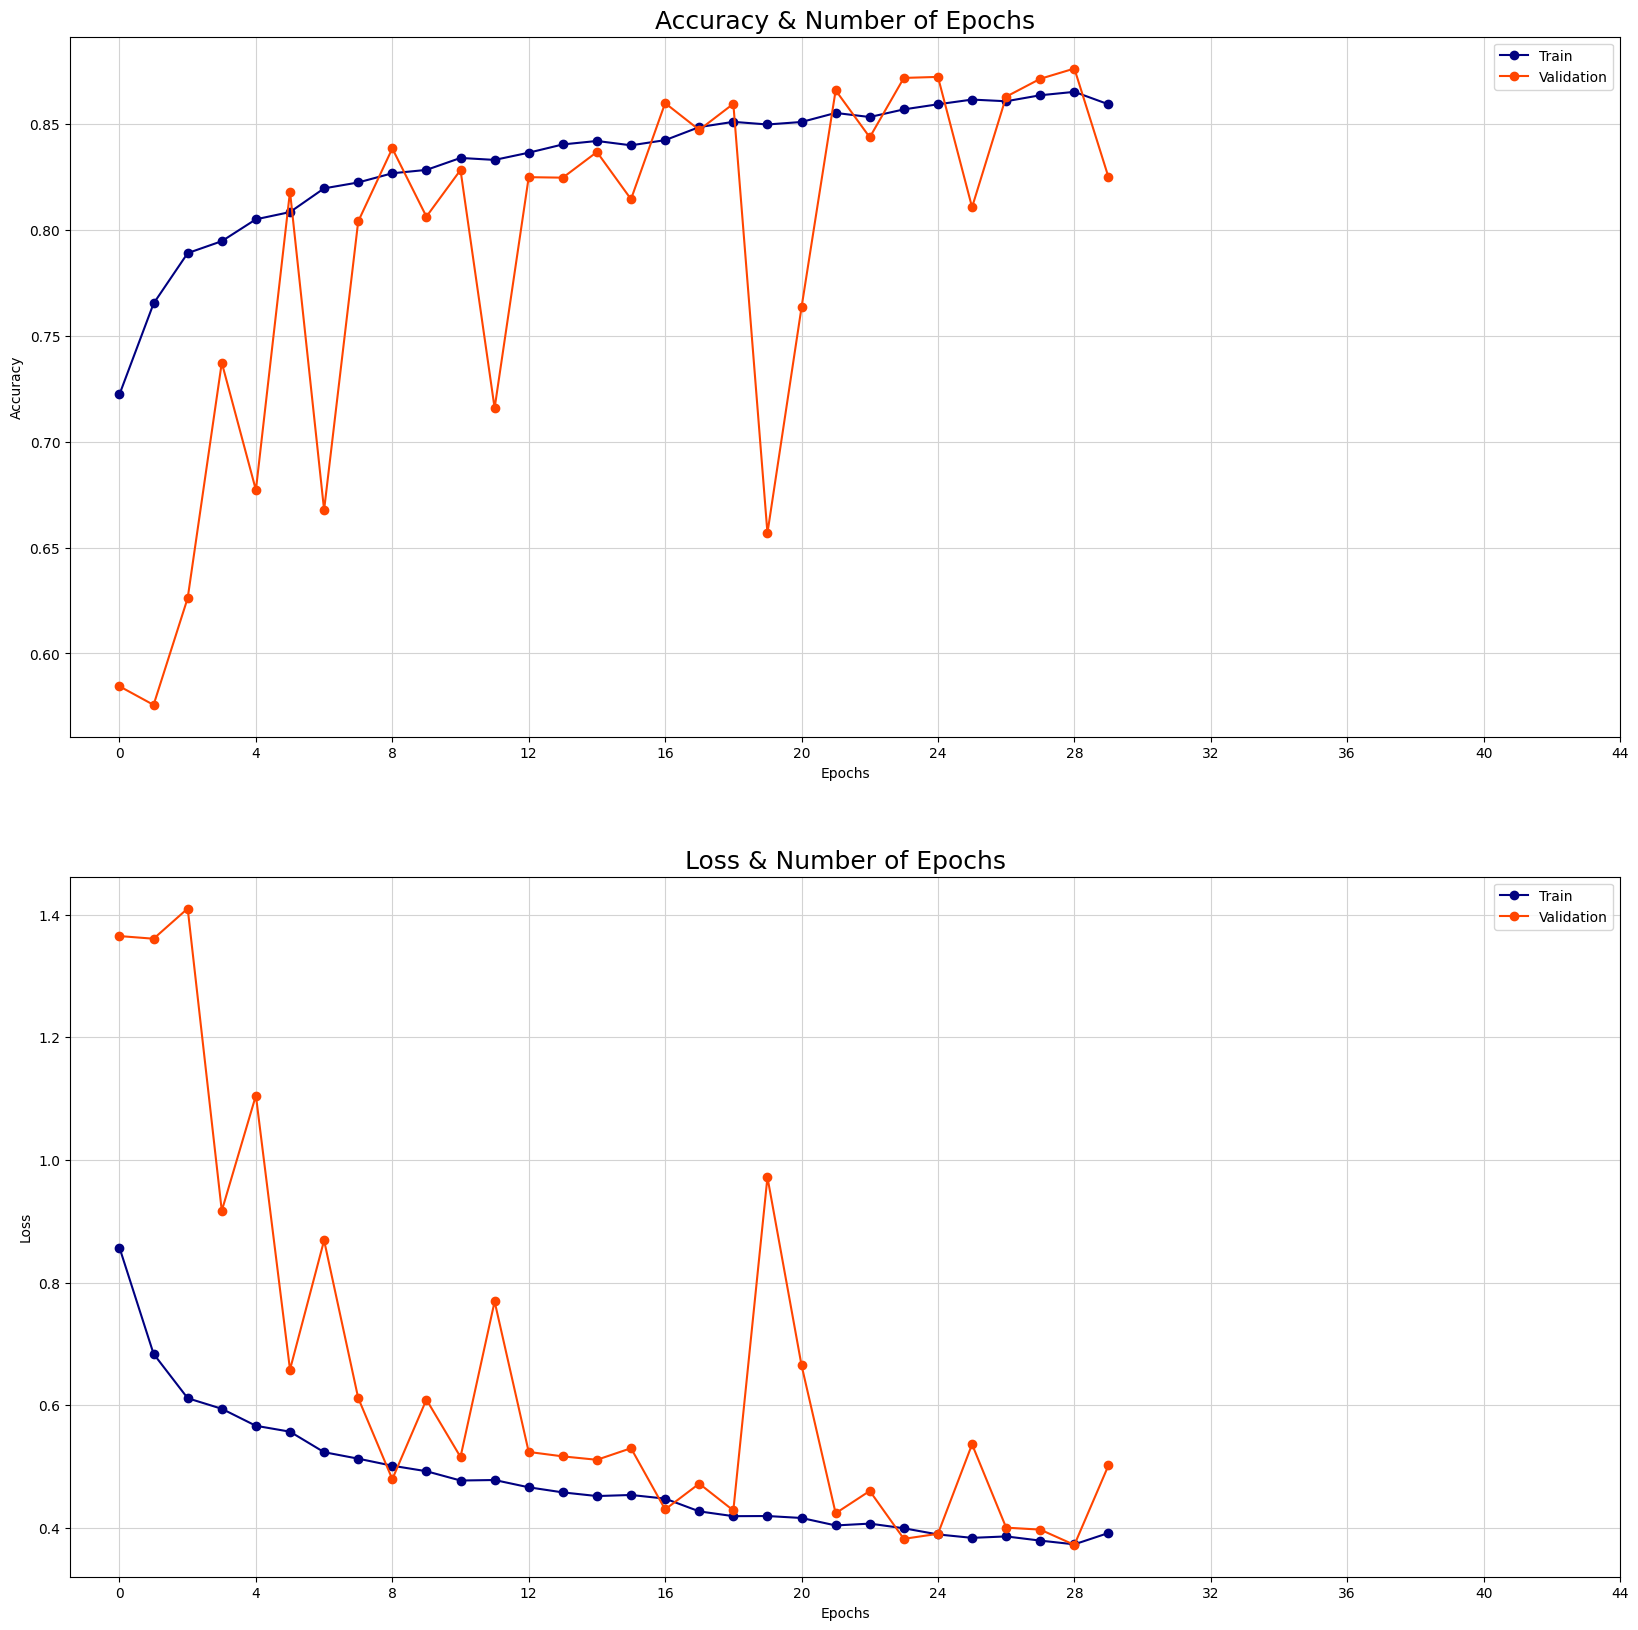

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax = ax.ravel()
metrics_Attention_unet = ['Accuracy', 'Loss']

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_Attention_unet.history[met], 'o-',color= 'navy')
    ax[i].plot(history_Attention_unet.history['val_' + met], 'o-',color= 'orangered')
    ax[i].set_title('{} & Number of Epochs'.format(metrics_Attention_unet[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics_Attention_unet[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")



In [27]:
y_pred_Attention_unet=Attention_unet_model.predict(X_test)

9/9 [==============================] - 1s 89ms/step


In [28]:
Attention_unet_model.save("Attention_Unet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Result

In [29]:
# load models
satellite_model_unet = load_model('./drive/MyDrive/Colab Notebooks/CNN_Unet.h5', compile=True, safe_mode=True)
satellite_model_VGG19 = load_model('./drive/MyDrive/Colab Notebooks/VGG19_Unet.h5', compile=True, safe_mode=True)
satellite_model_Densenet = load_model('./drive/MyDrive/Colab Notebooks/Densenet_Unet.h5', compile=True, safe_mode=True)
satellite_model_Attention_unet = load_model('./Attention_Unet.h5', compile=True, safe_mode=True)

In [30]:
# Comparing Acc & Loss of models
loss_unet,acc_unet= satellite_model_unet.evaluate(X_test, y_test, verbose=1)
print("accuracy CNN Unet:", acc_unet , " | ", "loss CNN Unet:", loss_unet)
loss_VGG,acc_VGG= satellite_model_VGG19.evaluate(X_test, y_test, verbose=1)
print("accuracy VGG19:", acc_VGG , " | ", "loss VGG19:", loss_VGG)
loss_Densenet,acc_Densenet= satellite_model_Densenet.evaluate(X_test, y_test, verbose=1)
print("accuracy Densenet-121:", acc_Densenet , " | ", "loss Densenet-121:", loss_Densenet)
loss_Attention_unet,acc_Attention_unet= satellite_model_Attention_unet.evaluate(X_test, y_test, verbose=1)
print("accuracy Attention Unet:", acc_Attention_unet , " | ", "loss Attention Unet:", loss_Attention_unet)

9/9 [==============================] - 5s 164ms/step - loss: 0.3762 - accuracy: 0.8740
accuracy CNN Unet: 0.8740216493606567  |  loss CNN Unet: 0.3762039840221405
9/9 [==============================] - 5s 172ms/step - loss: 0.3599 - accuracy: 0.8896
accuracy VGG19: 0.8895565867424011  |  loss VGG19: 0.35987624526023865
9/9 [==============================] - 6s 235ms/step - loss: 0.3906 - accuracy: 0.8905
accuracy Densenet-121: 0.8905196785926819  |  loss Densenet-121: 0.3905699551105499
9/9 [==============================] - 1s 89ms/step - loss: 0.5016 - accuracy: 0.8250
accuracy Attention Unet: 0.825042188167572  |  loss Attention Unet: 0.501639187335968


In [31]:
# make prediction
y_pred_unet=satellite_model_unet.predict(X_test)
y_pred_VGG19=satellite_model_VGG19.predict(X_test)
y_pred_Densenet=satellite_model_Densenet.predict(X_test)
y_pred_Attention_unet=satellite_model_Attention_unet.predict(X_test)

y_pred_argmax_inception=np.argmax(y_pred_unet, axis=3)
y_pred_argmax_VGG19=np.argmax(y_pred_VGG19, axis=3)
y_pred_argmax_Densenet=np.argmax(y_pred_Densenet, axis=3)
y_pred_argmax_Attention_unet=np.argmax(y_pred_Attention_unet, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


9/9 [==============================] - 1s 84ms/step


1/1 [==============================] - 0s 23ms/step


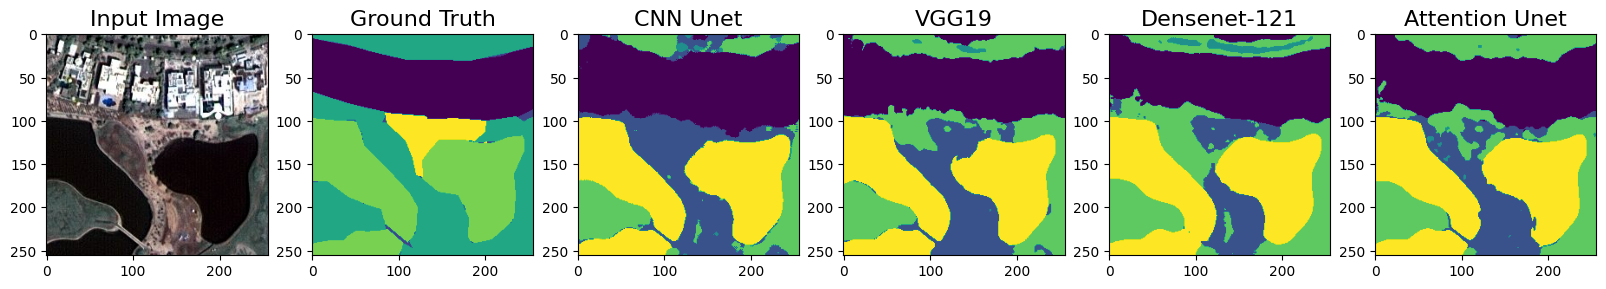

1/1 [==============================] - 0s 24ms/step


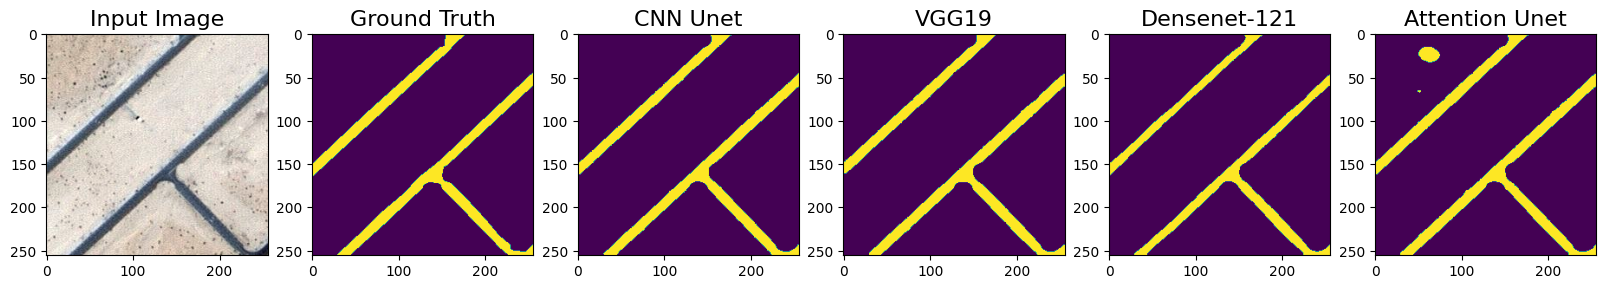

1/1 [==============================] - 0s 23ms/step


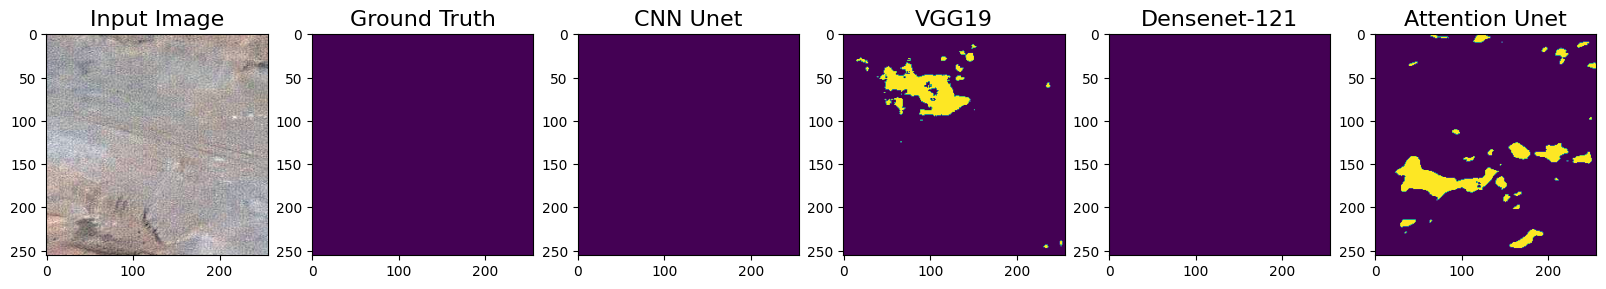

1/1 [==============================] - 0s 23ms/step


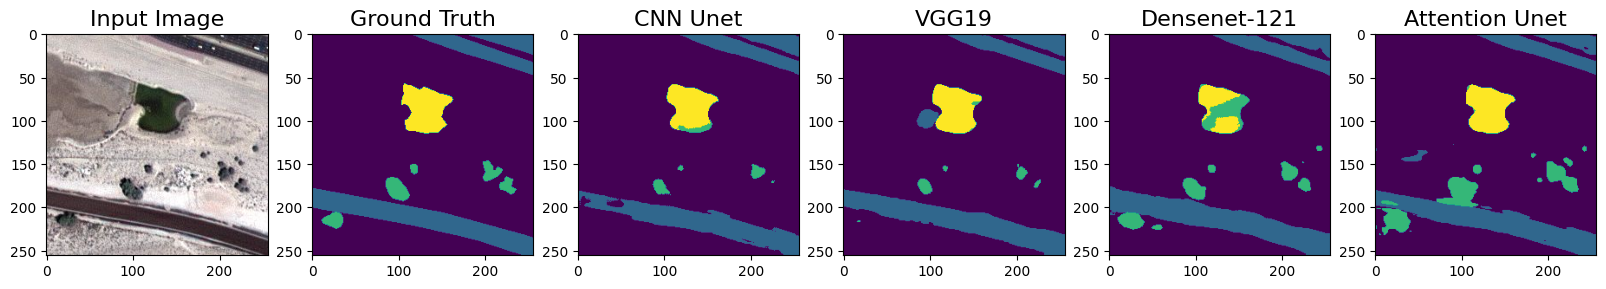

1/1 [==============================] - 0s 24ms/step


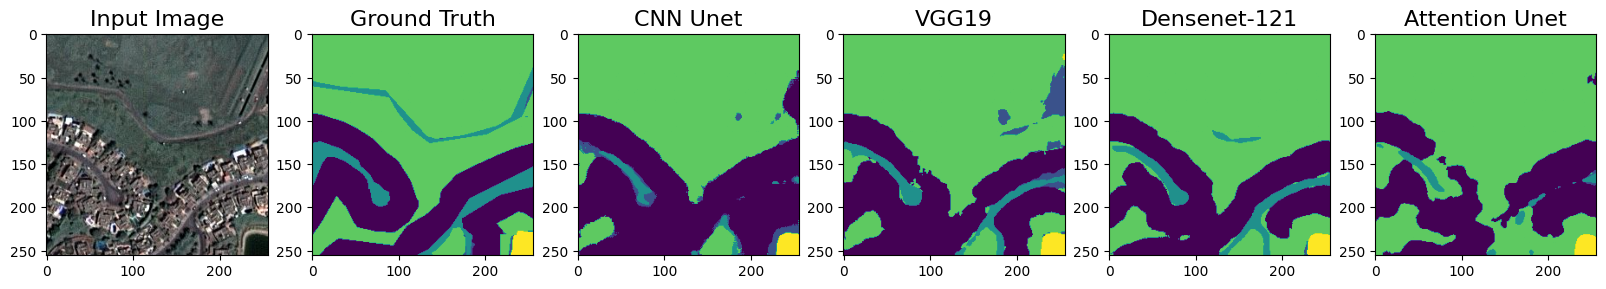

In [34]:
for i in range(5):
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1,6,1)
    ax1.imshow(X_test[i])
    ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax1.grid(False)

    ax2 = fig.add_subplot(1,6,2)
    ax2.set_title('Ground Truth', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax2.imshow(y_test_argmax[i])
    ax2.grid(False)

    ax3 = fig.add_subplot(1,6,3)
    ax3.set_title('CNN Unet', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax3.imshow(np.argmax(satellite_model_unet.predict(np.expand_dims(X_test[i], 0)), axis=3)[0,:,:])
    ax3.grid(False)

    ax4 = fig.add_subplot(1,6,4)
    ax4.set_title('VGG19', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax4.imshow(np.argmax(satellite_model_VGG19.predict(np.expand_dims(X_test[i], 0)), axis=3)[0,:,:])
    ax4.grid(False)

    ax5 = fig.add_subplot(1,6,5)
    ax5.set_title('Densenet-121', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax5.imshow(np.argmax(satellite_model_Densenet.predict(np.expand_dims(X_test[i], 0)), axis=3)[0,:,:])
    ax5.grid(False)

    ax6 = fig.add_subplot(1,6,6)
    ax6.set_title('Attention Unet', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax6.imshow(np.argmax(satellite_model_Attention_unet.predict(np.expand_dims(X_test[i], 0)), axis=3)[0,:,:])
    ax6.grid(False)

    plt.show()